# Markdown documentation of the project has been abandoned at a relatively early stage
## Some of the comments may not be relevant anymore
### Extra work would be needed to clean up the code from all inconsistencies/inefficiencies and document everything, before it can be used with full convenience

This cell does the following:
 - Import libraries
 - Create a list of asteroid numbers that are known to be active asteroids
 - Create a dictionary object *Asteroid_info_dict* - it will store information about an asteroid (name, semi-major axis, eccentricity,inclination,diameter,rotational_period) whenever available and all the spectra accessed
 - Define several functions

Function ***asteroid_reference_string*** is for printing and plotting. For an asteroid with number **x** and name *y* it would return "asteroid **x**" if the name is not known and "asteroid **x** *y*" if the name is known

Function ***recursive_subdirectory_search*** extracts all subdirectories of an online data folder available at a given *link*

In [1]:
import wget
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import mpltern
from bs4 import BeautifulSoup
import requests
import cana
import scipy as scp
import pandas as pd

if not os.path.exists("./data/"):
    os.mkdir("./data/")
    
Known_active_asteroids=[1,4015,7968,118401,300163,248370,493,596,2201,3200,6478,62412,101955]

Asteroid_info_dict={}
Average_albedos_dict={}

def asteroid_refrence_string(num):
        if not (Asteroid_info_dict[num]["name"]=="?"):
            return "asteroid {} {}".format(num,Asteroid_info_dict[num]["name"])            
        else:
            return "asteroid {}".format(num)
    
def recursive_subdirectory_search(link):
    page = requests.get(link).text
    soup = BeautifulSoup(page, 'html.parser')
    subdirs = [node.get('href') for node in soup.find_all('a') if node.get('href').endswith("/")]
    subdirs=list(map(lambda x: link+x,subdirs[1:]))
    if len(subdirs)==0:
        return []
    else:
        return subdirs+[item for sublist in list(map(lambda x: recursive_subdirectory_search(x),subdirs)) for item in sublist]

def extract_asteroid_info_to_file(file_name,append="w"):
    f = open(file_name, append)
    for key in Asteroid_info_dict:
        f.write("{},{},{},{},{},{},{},{}\n".format(key,Asteroid_info_dict[key]["name"],Asteroid_info_dict[key]["a"],Asteroid_info_dict[key]["e"],Asteroid_info_dict[key]["i"],Asteroid_info_dict[key]["diameter"],Asteroid_info_dict[key]["rot_per"],Asteroid_info_dict[key]["albedo"]))

def extract_asteroid_from_a_file(file_name):
    numbers=np.genfromtxt(file_name,dtype='U',delimiter=",",usecols=[0])
    names=np.genfromtxt(file_name,dtype='U',delimiter=",",usecols=[1])
    a=np.genfromtxt(file_name,usecols=[2],delimiter=",")
    e=np.genfromtxt(file_name,usecols=[3],delimiter=",")
    i=np.genfromtxt(file_name,usecols=[4],delimiter=",")
    d=np.genfromtxt(file_name,usecols=[5],delimiter=",")
    p=np.genfromtxt(file_name,usecols=[6],delimiter=",")
    alb=np.genfromtxt(file_name,usecols=[7],delimiter=",")
    for j in range(len(numbers)):
        Asteroid_info_dict[numbers[j]]={}    
        Asteroid_info_dict[numbers[j]]["name"]=names[j]
        Asteroid_info_dict[numbers[j]]["a"]=a[j]
        Asteroid_info_dict[numbers[j]]["e"]=e[j]
        Asteroid_info_dict[numbers[j]]["i"]=i[j]
        Asteroid_info_dict[numbers[j]]["diameter"]=d[j]
        Asteroid_info_dict[numbers[j]]["rot_per"]=p[j]    
        Asteroid_info_dict[numbers[j]]["spectra"]=[]
        Asteroid_info_dict[numbers[j]]["albedo"]=alb[j]
        Asteroid_info_dict[numbers[j]]["taxonomy"]="?"
        
def query_sbdb(num):
    link="https://ssd-api.jpl.nasa.gov/sbdb_query.api?fields=name,a,e,i,diameter,rot_per,albedo&sb-cdata=%7B%20%22AND%22%20%3A%20%5B%20%22spkid%7CEQ%7C{}%22%20%5D%20%7D%0A".format(20000000+int(num))
    try:
        page = requests.get(link).text
        data = eval(BeautifulSoup(page, 'html.parser').text.replace("null","{}nan{}".format(chr(34),chr(34))))["data"][0]
        if data[0]=="nan":
            data[0]="?"
        Asteroid_info_dict[num]["name"]=data[0]
        Asteroid_info_dict[num]["a"]=data[1]
        Asteroid_info_dict[num]["e"]=data[2]
        Asteroid_info_dict[num]["i"]=data[3]
        Asteroid_info_dict[num]["diameter"]=data[4]
        Asteroid_info_dict[num]["rot_per"]=data[5]
        Asteroid_info_dict[num]["albedo"]=data[6]
    except:
        Asteroid_info_dict[num]["name"]="?"
        Asteroid_info_dict[num]["a"]="nan"
        Asteroid_info_dict[num]["e"]="nan"
        Asteroid_info_dict[num]["i"]="nan"
        Asteroid_info_dict[num]["diameter"]="nan"
        Asteroid_info_dict[num]["rot_per"]="nan"
        Asteroid_info_dict[num]["albedo"]="nan"

def temperature_estimation(num,d=None):
    A=Asteroid_info_dict[num]["albedo"]
    #if np.isnan(A) or A=="nan":
    if np.isnan(A):
        return Average_albedos_dict[Asteroid_info_dict[num]["taxonomy"]]
    a=Asteroid_info_dict[num]["a"]*1.496*10**11
    e=Asteroid_info_dict[num]["e"]
    if d is None:
        d=a
    elif d<a*(1-e) or d>a*(1+e):
        print("Suspicious d value. It should be between {} and {} AU but {} AU was provided".format(a*(1-e)/(1.496*10**11),a*(1+e)/(1.496*10**11),d/(1.496*10**11)))
    eps=0.9
    L=3.827*10**26
    sigma=5.67*10**(-8)
    return ((1-A)*L/(16*eps*sigma*np.pi*d**2))**0.25
  
def setup_average_albedo_dict():
    keys=["S","Sa","Sq","Sr","Sv","B","C","Cb","Cg","Cgh","Ch","X","Xc","Xe","Xk","T","D","Q","O","R","V","A","K","L"]
    for key in keys:
        alb=0
        n=0
        for num in Asteroid_info_dict.keys():
            if Asteroid_info_dict[num]["taxonomy"]==key:
                #if not (np.isnan(Asteroid_info_dict[num]["albedo"]) or Asteroid_info_dict[num]["albedo"]=="nan"):
                if not np.isnan(Asteroid_info_dict[num]["albedo"]):
                    alb+=Asteroid_info_dict[num]["albedo"]
                    n+=1
        if n>0:
            Average_albedos_dict[key]=alb/n
    

    
def tax_from_taxkey(taxkey):
    if taxkey in ["S","Sa","Sq","Sr","Sv"]:
        return "S-complex"
    elif taxkey in["B","C","Cb","Cg","Cgh","Ch"]:
        return "C-complex"
    elif taxkey in ["X","Xc","Xe","Xk"]:
        return "X-complex"
    else:
        return "End members"

In [2]:
extract_asteroid_from_a_file("asteroid_info.txt")

Here we define two classes: a **database** class and a child **spectrum** class. 

The **database** is created with a link to the database, where the spectra are available, a *tag* which will be a name the database will be referred by when printing information and plotting. The normalization wavelength should also be provided at initialization and is stored as an attribute.

Running ***print*** on a **database** object will result in a report on the asteroids the spectra of which are stored, including whether multiple spectra are available for the same asteroid and if any of the asteroids belongs to a small list of known active asteroids.

Function ***change_directory_name*** changes (in place, using the *os* module) the name of the directory to store the data from that database, and optionally sets a new *tag*.

The method ***download_all*** of the **database** object downloads all the data available in that database. Spectra are saved in a relevant directory, described by a *dir* attribute. For each spectrum, a **spectrum** object is created. The **database** object acquires an attribute spectra, which is a dictionary, where a key is the asteroid number (extracted from a filename) and the entry is a list of all **spectrum** objects containing spectra of that asteroid within a given database. These spectra are then also added to the  *Asteroid_info_dict* dictionary. 

> There are several issues related to the fact that data is stored a bit differently in different databases. So far the following issues arose and were resolved by modifications I added to the code:
> - Some databases provide the name of the asteroid in the filename, while others only provide a number. It is pleasant to extract the names of the asteroids. Therefore we do this whenever possible and save these names in the global *Asteroid_names_dict* dictionary. However, it would lead to an error if the file names do not contain asteroid names. If they do appear in a given databes it's flag *extract_asteroid_names* should be set to **True**
> - In some databases spectra are not in a single directory, but are subdivided among directories. To download them, a recursive search among subdirectories (using the ***recursive_subdirectory_search***) will be run to retrieve all relevant links to available spectra. This is done by the ***identify_available_spectra*** function.
> - In some cases filenames keep an equal length by introducing additional zeroes in front of the asteroid number. Therefore, I had to modify the code to disregard initial characters as long as something other than $0$ comes up in the filename string.
> - Default data file extension is *.tab*, but in some cases it is different, such as *.csv*. The data in this format is separated by comas instead of spaces. To handle these situations, I gave the database an *ext* attribute to store the file extension, it's default value set to *.tab*. The delimiter is determined automatically from reading the file. 
> - In the SMASS databases, some of the files have wavelengths in Å instead of $\mu$m. As it was the case for all SMASS I files, I initially handled this by adding a \textit{wavelength\_factor}$=10^{-4}$ parameter to multiply all the wavelengths. However, it later turned out that in SMASS II it only applies to a part of the files. At least for now, this is handed by a brutal approach of checking if the wavelength range starts in thousands, and multiplying by $=10^{-4}$ if that's the case (when downloading each individual spectrum).

> The function ***download_all*** has flags *plot* and *save_plots*. If they are set to **True**, plots of all spectra will be generated, and saved on the computer, respectively.

> While downloading, this method will also update a total range of wavelengths existent in the database (*self.wavelength_range*)

Function ***plot_all_together*** plots all the spectra from one database, if an asteroid of a given number has multiple spectra there. It can also save the plot to a desired file name with a desired extension.

___

An instance of the **spectrum** class stores information related to one specific spectrum. It is a child class of **database** because it stores some of the same information, such as the relevant database link and normalization wavelength.

Method ***download*** downloads the spectrum from the relevant link. It is both saved as a text file and stored as array attributes (*wavelengths*,*reflectance*,*err*). In some cases, files contain two columns only, as the error on reflectance is not provided. In this case, the attribute *err* becomes an array of zeroes. The *wavelength_range* is adjusted accordingly. 

If a flag *instant_download* is set to **True** upon creation of a **spectrum** object, the function ***download*** is run immediately.

Method ***plot_spectrum*** plots the spectrum. By default, it also includes error bars and marks the normalization wavelength with a red vertical line. It can also save the plot to a desired file name with a desired extension.
> Functionality of *return_ax*, *receive_ax* is just for calling the ***plot_spectrum*** inside the ***plot_all_together*** function of the **database** class to add plots to the same **fig, ax** object

The function ***renormalize*** multiplies a spectrum by a constant in order to:
 - Normalize it at *new_wavelength*, unless *around_wavelength* is set to **False**
 - Additionally scale it by *scale_factor* ($1$ by default, i. e. no extra scaling)
 > If the flag of *create_new_object* is set to False, only an array of renormalized reflectances is returned. Overwise, a new **spectrum** object with renormalized reflectance is returned

The function ***average_smoothing*** applies average smoothing over a defined window size (symmetrical)
 > If the flag of *create_new_object* is set to False, only an array is returned, with dimensions matching the original wavelength and reflectance arrays. Overwise, a new **spectrum** object with averaged reflectances and trimmed wavelengths is returned
 
The function ***cana_spectrum*** returns a *cana.spec.Spectrum* object with the spectrum

The function ***apply_and_compare*** uses the *cana* module to make a quick comparison of plots of the original spectrum and a spectrum on which a certain preprocessing procedure has been conducted. The function *fun* should be a function that takes a *cana.Spectrum* object and returns a *cana.Spectrum* object if the flag *cana_function* is set to true and take and return a **spectrum** object otherwise (can be **lambda** g: self.g, where g is a method of the class **spectrum**)

In [3]:
import matplotlib.cm as cm
marker_dict={1:".",2:"o",3:"v",4:"^",5:"<",6:">",7:"1",8:"2",9:"3",10:"4",11:"8",12:"s",13:"p",14:"P",15:"*",16:"h",18:"H",17:"+",19:"x",20:"X",21:"D",0:"d"}
label_dict={"a":"semi-major axis [AU]","e":"eccentricity","i":"inclination"r'$[^\circ]$',"diameter":"diameter[km]","rot_per":"synodic rotational period [h]","albedo":"albedo"}


class spectrum_database:

    def __init__(self,tag,database_path,spectra_folder,normalization_wavelength,extract_asteroid_names=False,extract_observation_dates=False,number_starting_filename_only=True,skip_beginning_of_filename=0,ext="tab",wavelength_factor=1):
        self.tag = tag
        self.database = database_path
        self.directories=[self.database]
        self.available_spectra={}
        self.dir=spectra_folder+"/"
        self.ext=ext
        self.extract_asteroid_names=extract_asteroid_names
        self.extract_observation_dates=extract_observation_dates
        self.skip_beginning_of_filename=skip_beginning_of_filename
        self.wavelength_range=[np.inf,-np.inf]
        self.number_starting_filename_only=number_starting_filename_only
        if not os.path.exists("./data/"+self.dir):
            os.mkdir("./data/"+self.dir)
            os.mkdir("./plots/"+self.dir)
        self.normalization_wavelength=normalization_wavelength
        self.wavelength_factor=wavelength_factor
        
    def report(self, print_report=True, print_names=True, make_histogram=False,figsize=(10,7),nonzero=False,nonambiguous=True,save_plot=False,save_format="png",properties_dependent_plot=False,property_x="a",property_y="diameter",cmaps={"C-complex":cm.Greys,"S-complex":cm.Blues,"X-complex":cm.Oranges,"End members":cm.Purples}):
        s="Dataset {} representing reflectance spectra of asteroids.\n\nWavelength range: {:0.2f} - {:0.2f} microns.\nReflectance normalized to 1 at {} microns.\nCurrently storing spectra of the following {} asteroids:\n".format(self.tag,self.wavelength_range[0],self.wavelength_range[1],self.normalization_wavelength,len(self.spectra))
        if make_histogram:
            labels = []
            occurrences = []
            occurrences_na = []
        if nonambiguous:
            ambiguity_string="filetring out cases with ambiguity"
        else:
            ambiguity_string="with possible ambiguities"
        if properties_dependent_plot:
            fig_pd, ax_pd = plt.subplots(1,1,figsize=figsize)
            ax_pd.set_xlabel(label_dict[property_x])
            ax_pd.set_ylabel(label_dict[property_y])
            ax_pd.set_title("Taxonomic classification of asteroid spectra from the {} database,\n in the parameter space of {} and {} ".format(self.tag,label_dict[property_x],label_dict[property_y]),y=1.05,fontsize=14)
        S=0
        tax_categories_order=[name for name in ["C-complex","S-complex","X-complex","End members"] if name in self.taxonomies.keys()]
        tics=[]
        it=0
        ix=0
        for tax in tax_categories_order:
            st="\n{}:\n\n".format(tax)
            ixx=0
            for taxkey in self.taxonomies[tax]:
                ix+=1
                ixx+=1
                n = len(self.taxonomies[tax][taxkey])
                if properties_dependent_plot:
                    abssicas=[]
                    ordinates=[]
                    for i in range(n):
                        ast_num=self.taxonomies[tax][taxkey][i][0]
                        abssicas.append(Asteroid_info_dict[ast_num][property_x])
                        ordinates.append(Asteroid_info_dict[ast_num][property_y])
                    if n>0:
                        ax_pd.scatter(abssicas,ordinates,label=taxkey,marker=marker_dict[ix%22],color=color_dict[tax](1-ixx/20))
                n2 = len([self.taxonomies[tax][taxkey][i] for i in range(n) if not self.taxonomies[tax][taxkey][i][1]])
                S+=n-n2
                if make_histogram:
                    if n>0 or not nonzero:
                        labels.append(taxkey)
                        occurrences.append(n)
                        occurrences_na.append(n2)
                        tics.append(it)
                        it+=1
                if n>0:
                    if nonambiguous and n>n2:
                        st+="\n    Taxonomic class {} ({} asteroids certain, {} ambiguous):\n\n".format(taxkey,n2,n-n2)
                    else:
                        st+="\n    Taxonomic class {} ({} asteroids):\n\n".format(taxkey,n)
                    for i in range(len(self.taxonomies[tax][taxkey])):
                        key=self.taxonomies[tax][taxkey][i][0]
                        if print_names:
                            st+="        "+key+" {}".format(Asteroid_info_dict[key]["name"])
                        else:
                            st+="        "+key
                        t=" ("
                        if (key in Known_active_asteroids):
                            t+="active asteroid,"
                        if (len(self.spectra[key])>1):
                            t+="{} different spectra,".format(len(self.spectra[key]))
                        if self.taxonomies[tax][taxkey][i][1]:
                            t+="ambiguous taxonomic classification,"
                        if not (t==" ("):
                            st+=t[:-1]
                            st+=")"
                        st+="\n"
            if not st=="\n{}:\n\n".format(tax):
                s+=st
                it+=1
        if properties_dependent_plot:
            ax_pd.legend(ncol=2)
            if save_plot:
                fig_pd.savefig("taxonomic_classifiacation_{}_{}_{}.{}".format(self.tag,property_x,property_y,save_format))
                plt.close()
        if make_histogram:
            fig, ax = plt.subplots(1,1,figsize=figsize)
            if nonambiguous:
                if S>0:
                    labels.append("Ambiguous")
                    occurrences_na.append(S)
                    tics.append(tics[-1]+3)
                ax.bar(tics,occurrences_na)
                
            else:
                ax.bar(tics,occurrences,color="r",label="Ambiguous")
                ax.bar(tics,occurrences_na,label="Non-ambiguous")
                ax.legend()
            ax.set_xticks(tics,labels=labels)
            ax.set_title("Taxonomic classification of asteroid spectra from the {} database\n".format(self.tag)+ambiguity_string,y=1.05,fontsize=14)
            ax.set_ylabel("Number of occurrences")
            ax.set_xlabel("Taxonomic class")
            if save_plot:
                fig.savefig("taxonomic_classifiacation_{}_{}.{}".format(self.tag,ambiguity_string,save_format))
                plt.close()
        if print_report:
            print(s)
    
    def change_directory_name(self,new_name,new_tag=None):
        os.rename("./data/"+self.dir,"./data/"+new_name)
        self.dir=new_name+"/"
        if not new_tag is None:
            self.tag=new_tag
        
    def identify_available_spectra(self):
        self.directories+=recursive_subdirectory_search(self.database)
        for directory in self.directories:
            page = requests.get(directory).text
            soup = BeautifulSoup(page, 'html.parser')
            self.available_spectra[directory] = [node.get('href') for node in soup.find_all('a') if node.get('href').endswith(self.ext)]
            if self.number_starting_filename_only:
                to_remove=[]
                for file_name in self.available_spectra[directory]:
                    if not file_name[self.skip_beginning_of_filename].isdigit():
                        to_remove.append(file_name)
                for file_name in to_remove:
                    self.available_spectra[directory].remove(file_name)
        
    def download_all(self,plot=False,save_plots=False,plot_figsize=(7,7),save_plot_format=".png",load_previously_downloaded=False,observation_dates_text_file=None,save_observation_dates_to_file=False):
        if load_previously_downloaded:
            self.directories=["./data/"+self.dir]
            self.available_spectra={"./data/"+self.dir:os.listdir("./data/"+self.dir)}
        else:
            self.identify_available_spectra()
        if save_observation_dates_to_file:
            fff = open(observation_dates_text_file, "a")
        elif self.extract_observation_dates and not (observation_dates_text_file is None):
            numbers=np.genfromtxt(observation_dates_text_file,dtype='U',usecols=[0])
            observation_dates=np.genfromtxt(observation_dates_text_file,dtype='U',usecols=[1])
            heliocentric_distances=np.genfromtxt(observation_dates_text_file,usecols=[2])
            phase_angles=np.genfromtxt(observation_dates_text_file,usecols=[3])
            observation_specific_dict={}
            for i in range(len(numbers)):
                if numbers[i] in observation_specific_dict.keys():
                    observation_specific_dict[numbers[i]][observation_dates[i]]=[heliocentric_distances[i],phase_angles[i]]
                else:
                    observation_specific_dict[numbers[i]]={observation_dates[i]:[heliocentric_distances[i],phase_angles[i]]}
        else:
            observation_dates=["nan"]
        self.spectra={}
        self.asteroid_taxonomic_classification={}
        helper_taxonomy_info={}
        helper_taxonomy_info_weights={}
        all_taxonomies={}
        self.taxonomies={"S-complex":{"S":[],"Sa":[],"Sq":[],"Sr":[],"Sv":[]},"C-complex":{"B":[],"C":[],"Cb":[],"Cg":[],"Cgh":[],"Ch":[]},"X-complex":{"X":[],"Xc":[],"Xe":[],"Xk":[]},"End members":{"T":[],"D":[],"Q":[],"O":[],"R":[],"V":[],"A":[],"K":[],"L":[]}}
        for directory in self.directories:
            for file_name in self.available_spectra[directory]:
                observation_date="nan"
                phase_angle="nan"
                heliocentric_distance="nan"
                name_to_pass=directory+file_name
                if load_previously_downloaded:
                    self.extract_asteroid_names=False
                    load_from_file=name_to_pass
                    i=0
                    k=0
                else:
                    i = self.skip_beginning_of_filename
                    k = self.skip_beginning_of_filename
                    load_from_file=None
                while file_name[k]=="0":
                    k+=1
                    i+=1
                while file_name[i].isdigit():
                    i+=1
                if (self.extract_asteroid_names):
                    j=i
                    while file_name[j].isalpha():
                        j+=1
                    asteroid_name = file_name[i:j].capitalize()
                asteroid_number = file_name[k:i]
                if (self.extract_observation_dates):
                    j=i
                    while not file_name[j].isnumeric():
                        j+=1
                    if load_previously_downloaded:
                        observation_date=file_name[j:j+10]
                        if not save_observation_dates_to_file:
                            phase_angle=observation_specific_dict[asteroid_number][observation_date][1]
                            heliocentric_distance=observation_specific_dict[asteroid_number][observation_date][0]
                        else:
                            phase_angle="nan"
                            heliocentric_distance="nan"
                    else:
                        observation_date="20"+file_name[j:j+2]+"-"+file_name[j+2:j+4]+"-"+file_name[j+4:j+6]
                if asteroid_number in self.spectra:
                    self.spectra[asteroid_number].append(spectrum(asteroid_number,observation_date,self,name_to_pass,phase_angle=phase_angle,heliocentric_distance=heliocentric_distance,instant_download=True,load_from_file=load_from_file,spectrum_instance_within_database=len(self.spectra[asteroid_number])))
                    if(save_observation_dates_to_file):
                        fff.write("{} {} {} {}\n".format(asteroid_number,observation_date,self.spectra[asteroid_number][-1].heliocentric_distance,self.spectra[asteroid_number][-1].phase_angle))
                    for i in range(3):
                        taxkey=self.spectra[asteroid_number][-1].taxonomy_options[i]
                        if not taxkey in all_taxonomies[asteroid_number]:
                            all_taxonomies[asteroid_number].append(taxkey)
                            helper_taxonomy_info[asteroid_number][taxkey]=list(map(lambda x: 2*max(self.spectra[asteroid_number][x].taxonomy_chi2s)-min(self.spectra[asteroid_number][x].taxonomy_chi2s),range(len(self.spectra[asteroid_number])-1)))
                            helper_taxonomy_info_weights[asteroid_number][taxkey]=list(map(lambda x: len(self.spectra[asteroid_number][x].wavelengths)/min(self.spectra[asteroid_number][x].taxonomy_chi2s),range(len(self.spectra[asteroid_number])-1)))
                        helper_taxonomy_info[asteroid_number][taxkey].append(self.spectra[asteroid_number][-1].taxonomy_chi2s[i])
                        helper_taxonomy_info_weights[asteroid_number][taxkey].append(len(self.spectra[asteroid_number][-1].wavelengths)/min(self.spectra[asteroid_number][-1].taxonomy_chi2s))
                    for taxkey in all_taxonomies[asteroid_number]:
                        if not taxkey in self.spectra[asteroid_number][-1].taxonomy_options:
                            helper_taxonomy_info[asteroid_number][taxkey].append(2*max(self.spectra[asteroid_number][-1].taxonomy_chi2s)-min(self.spectra[asteroid_number][-1].taxonomy_chi2s))
                            helper_taxonomy_info_weights[asteroid_number][taxkey].append(len(self.spectra[asteroid_number][-1].wavelengths)/min(self.spectra[asteroid_number][-1].taxonomy_chi2s))                                                  
                else:
                    self.spectra[asteroid_number]=[spectrum(asteroid_number,observation_date,self,name_to_pass,phase_angle=phase_angle,heliocentric_distance=heliocentric_distance,instant_download=True,load_from_file=load_from_file)]
                    if(save_observation_dates_to_file):
                        fff.write("{} {} {} {}\n".format(asteroid_number,observation_date,self.spectra[asteroid_number][-1].heliocentric_distance,self.spectra[asteroid_number][-1].phase_angle))
                    helper_taxonomy_info[asteroid_number]={}
                    helper_taxonomy_info_weights[asteroid_number]={}
                    all_taxonomies[asteroid_number]=[]
                    for i in range(3):
                        taxkey=self.spectra[asteroid_number][-1].taxonomy_options[i]
                        helper_taxonomy_info[asteroid_number][taxkey]=[self.spectra[asteroid_number][-1].taxonomy_chi2s[i]]
                        all_taxonomies[asteroid_number].append(taxkey)
                        helper_taxonomy_info_weights[asteroid_number][taxkey]=[len(self.spectra[asteroid_number][-1].wavelengths)/min(self.spectra[asteroid_number][-1].taxonomy_chi2s)]
                self.wavelength_range=[min(self.spectra[asteroid_number][-1].wavelength_range[0],self.wavelength_range[0]),max(self.spectra[asteroid_number][-1].wavelength_range[1],self.wavelength_range[1])]
                if asteroid_number in Asteroid_info_dict.keys():
                    Asteroid_info_dict[asteroid_number]["spectra"].append(self.spectra[asteroid_number][-1])
                else:
                    Asteroid_info_dict[asteroid_number]={}
                    query_sbdb(asteroid_number)
                    Asteroid_info_dict[asteroid_number]["spectra"]=[self.spectra[asteroid_number][-1]]
                    #if asteroid_name!="?" and asteroid_name!=Asteroid_info_dict[asteroid_number]["name"]:
                    #    print("Name of asteroid {} inferred from the file name ({}) does not match the name obtained from the SBDB database ({}). Verify.".format(asteroid_number,asteroid_name,Asteroid_info_dict[asteroid_number]["name"]))
                if plot:
                    self.spectra[asteroid_number][-1].plot_spectrum(save=save_plots,figsize=plot_figsize,file_format=save_plot_format)
        for key in helper_taxonomy_info.keys():
            ambiguous=False
            tax1=self.spectra[key][0].taxonomy
            i=1
            while i<len(self.spectra[key]):
                tax2=self.spectra[key][i].taxonomy
                if tax2!=tax1:
                    ambiguous=True
                    break
                i+=1
            if ambiguous:
                helper_mean=1.0
                for helper_tax in helper_taxonomy_info[key].keys():
                    new_mean=np.average(np.array(helper_taxonomy_info[key][helper_tax]),weights=helper_taxonomy_info_weights[key][helper_tax])
                    if new_mean<helper_mean:
                        tax1=helper_tax
                        helper_mean=new_mean
            taxonomy=tax1
            Asteroid_info_dict[key]["taxonomy"]=taxonomy
            if taxonomy[0]=="S":
                self.taxonomies["S-complex"][taxonomy].append([key,ambiguous])
            elif taxonomy[0]=="C" or taxonomy[0]=="B":
                self.taxonomies["C-complex"][taxonomy].append([key,ambiguous])
            elif taxonomy[0]=="X":
                self.taxonomies["X-complex"][taxonomy].append([key,ambiguous])
            else:    
                self.taxonomies["End members"][taxonomy].append([key,ambiguous])
                    
    def plot_all_together(self,asteroid_number,mark_normalization_wavelength=False,figsize=(7,7),save=False,file_format="png"):
        asteroid_number=str(asteroid_number)
        if (asteroid_number in self.spectra):
            if (len(self.spectra[asteroid_number])==1):
                print("Only one spectrum available, aborting.")
                return
            fig, ax = plt.subplots(figsize = figsize)
            for spect in self.spectra[asteroid_number]:
                fig, ax = spect.plot_spectrum(mark_errors=False,mark_normalization_wavelength=mark_normalization_wavelength,return_ax=True,receive_ax=True,fig=fig,ax=ax)
            ax.set_title("Different spectra of {}\nfrom the {} database".format(asteroid_refrence_string(asteroid_number),self.tag))
            if save:
                fig.savefig("{}_multiple_spectra_{}.{}".format(asteroid_number,self.tag,file_format))
            return
        else:
            print("Asteroid not present in the database, aborting.")
            return
        
    def auxiliary_data_latex_table(self):
        s=""
        for key in sorted(self.spectra.keys()):
            s+="{} & {} & {} & {} & {} & {} & {} & {}\\\\\n\\hline\n".format(key,Asteroid_info_dict[key]["name"],Asteroid_info_dict[key]["a"],Asteroid_info_dict[key]["e"],Asteroid_info_dict[key]["i"], Asteroid_info_dict[key]["diameter"],Asteroid_info_dict[key]["rot_per"],Asteroid_info_dict[key]["albedo"])
        return s
    
    def absorption_band_detection_statistics(self,taxkeys,smooth_win=29,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,search_around_wavelengths=[0.9,1.9],initial_widths=[0.2,0.5]):        
        s="Summary of absorption band detections for the spectra from {} database smoothed with a filter of size {}\n".format(self.tag,smooth_win)
        s+="Searching for bands around the set of wavelengths:{}\n".format(search_around_wavelengths)
        for taxkey in taxkeys:
            tax=tax_from_taxkey(taxkey)
            n=0
            st=""
            for dat in self.taxonomies[tax][taxkey]:
                num=dat[0]
                p=0
                stp=""
                for sp in self.spectra[num]:
                    sp.absorption_band_analysis(smooth=smooth_win,smooth_in_wavelength=False,minimum_width=minimum_width,minimum_depth=minimum_depth,marg_fac=marg_fac,plot=False,search_around_wavelengths=search_around_wavelengths,initial_widths=initial_widths,suppress_warnings=True)
                    if(len(sp.detected_absorption_bands)>0):
                        p=1
                        stp="{} {}".format(num,Asteroid_info_dict[num]["name"])
                    if(len(sp.detected_absorption_bands)==len(search_around_wavelengths)):
                        stp+=" (all bands)"
                        break
                st+=stp
                if not stp=="":
                    st+="\n"
                n+=p
            s+="Among {} asteroids from the {} class, {} had at least one of the bands detected ({:0.2f}%)\n\n{}\n".format(len(self.taxonomies[tax][taxkey]),taxkey,n,100*n/len(self.taxonomies[tax][taxkey]),st)
        print(s)
    
    def olivine_pyroxene_analysis(self,taxkey,figsize=(10,7),smooth_win=30,width_min=0.02,depth_min=0.01,marg_fac=0.05,plot=True,marker="o",color="blue",color2="black",color3="gray",marker_size=5,receive_ax=False,fig=None,ax=None,band_center_y_axis="I",SBDB_property=None,phase_angle_correction=False,temperature_correction=False,band_center_correction_type="HED",print_mineralogical_numbers_as_latex_table=False,print_date_specific_info=False,empirical_formulas="Dunn",ternary_plot=False,save_ternary_plot=False,save_format="png",ternary_alpha=0.25,ternary_color_dict={"Enstatite":"firebrick","Ferrosilite":"orangered","Pigeonite":"chocolate","Augite":"steelblue","Diopside":"green","Hedenbergite":"turquoise"},cmap=cm.plasma):
        tax=tax_from_taxkey(taxkey)
        B1Cs=[]
        B2Cs=[]
        BARs=[]
        B1Cs_no_correction=[]
        B2Cs_no_correction=[]
        BARs_no_correction=[]
        B1Cs_no_phase_correction=[]
        B2Cs_no_phase_correction=[]
        BARs_no_phase_correction=[]
        nums=[]
        date_info=[]
        empirical={}
        if not SBDB_property is None:  
            abssica=[]
        for dat in self.taxonomies[tax][taxkey]:
            num=dat[0]
            b1a=[]
            b2a=[]
            b1c=[]
            b2c=[]
            bar=[]
            bar_no_correction=[]
            b1c_no_correction=[]
            b2c_no_correction=[]  
            bar_no_phase_correction=[]
            b1c_no_phase_correction=[]
            b2c_no_phase_correction=[]  
            for sp in self.spectra[num]:
                sp.absorption_band_analysis(smooth=smooth_win,smooth_in_wavelength=False,minimum_width=width_min,minimum_depth=depth_min,marg_fac=marg_fac,plot=False,search_around_wavelengths=[0.9,1.9],initial_widths=[0.2,0.5])
                if (len(sp.detected_absorption_bands)==2):
                    b1a.append(sp.detected_absorption_bands[0].area)
                    b2a.append(sp.detected_absorption_bands[1].area)
                    b1c.append(sp.detected_absorption_bands[0].w_cen)
                    b2c.append(sp.detected_absorption_bands[1].w_cen)
                    bar.append(b2a[-1]/b1a[-1])
                    bar_no_correction.append(bar[-1])
                    b1c_no_correction.append(b1c[-1])
                    b2c_no_correction.append(b2c[-1])
                    dat_in=[sp.observation_date]
                    if temperature_correction:
                        if not sp.observation_date=="nan":
                            d=sp.heliocentric_distance
                            dat_in.append(d)
                        else:
                            d=None
                        T=temperature_estimation(num,d=d)
                        bar[-1]+=0.00075*T-0.23
                        if band_center_correction_type=="HED":
                            b1c[-1]+=0.01656-0.0000552*T
                            b2c[-1]+=0.05067-0.00017*T
                        elif band_center_correction_type=="OC":
                            b2c[-1]+=0.06-0.0002*T
                        bar_no_phase_correction.append(bar[-1])
                        b1c_no_phase_correction.append(b1c[-1])
                        b2c_no_phase_correction.append(b2c[-1])
                    if phase_angle_correction:
                        if not sp.observation_date=="nan":
                            phase=sp.phase_angle
                            if phase<25:
                                bar[-1]-=0.0292*phase
                            else:
                                bar[-1]-=0.0292*25
                            dat_in.append(phase)
                    date_info.append(dat_in)
            if(len(b1a)>0):
                BAR=np.mean(np.array(bar_no_correction))
                B1C=np.mean(np.array(b1c_no_correction))
                B2C=np.mean(np.array(b2c_no_correction))
                B1Cs_no_correction.append(B1C)
                B2Cs_no_correction.append(B2C)                    
                BARs_no_correction.append(BAR)
                BAR=np.mean(np.array(bar_no_phase_correction))
                B1C=np.mean(np.array(b1c_no_phase_correction))
                B2C=np.mean(np.array(b2c_no_phase_correction))
                B1Cs_no_phase_correction.append(B1C)
                B2Cs_no_phase_correction.append(B2C)                    
                BARs_no_phase_correction.append(BAR)
                BAR=np.mean(np.array(bar))
                B1C=np.mean(np.array(b1c))
                B2C=np.mean(np.array(b2c))
                B1Cs.append(B1C)
                B2Cs.append(B2C)                    
                BARs.append(BAR)
                nums.append(num)
                if not SBDB_property is None:
                    abssica.append(Asteroid_info_dict[num][SBDB_property])
                if empirical_formulas=="Cloutis":
                    empirical[num]={"opx":-0.242*BAR + 0.728}
                elif empirical_formulas=="Dunn":
                    empirical[num]={"opx":0.242*BAR+0.272,"fa":(-1284.9*B1C**2+2656.5*B1C-1342.3)/100,"fs":(-879.1*B1C**2+ 1824.9*B1C-921.7)/100}
                elif empirical_formulas=="Burbine":
                    fs1=(1023.4*B1C-913.82)/100
                    fs2=(205.86*B2C-364.3)/100
                    wo1=(396.1*B1C-360.55)/100
                    wo2=(79.905*B2C-148.333)/100
                    if num=="4":
                        print(num,fs1,wo1)
                    empirical[num]={"fs":fs1,"wo":wo1}
        if plot:
            if not receive_ax:
                fig, ax = plt.subplots(1,1,figsize=figsize)
                ax.set_xlabel("Band II area/Band I area ratio")
                ax.set_ylabel("Band {} center ["r'$\mu$'"m]".format(band_center_y_axis))
                ax.set_title("Band {} center vs band area ratio\n for {} class asteroids in the {} database".format(band_center_y_axis,taxkey,self.tag))
            if len(BARs)>0:
                if band_center_y_axis=="I":
                    BCs=B1Cs
                    BCs_no_correction=B1Cs_no_correction
                    BCs_no_phase_correction=B1Cs_no_phase_correction
                else:
                    BCs=B2Cs
                    BCs_no_correction=B2Cs_no_correction
                    BCs_no_phase_correction=B2Cs_no_phase_correction
                if not SBDB_property is None:
                    #ax.set_title("{} vs band area ratio for class {} asteroids in the {} database\n based on spectra smoothed with a window of size {}".format(label_dict[SBDB_property],taxkey,self.tag,smooth_win))
                    ax.set_xlabel(label_dict[SBDB_property])
                    ax.set_ylabel("Band II area/Band I area ratio")
                    ax.scatter(abssica,BARs,marker=marker,color=color,label=taxkey)
                else:
                    if temperature_correction and phase_angle_correction:
                        for i in range(len(BARs)):
                            make_arrow_smaller=1
                            if abs(BARs_no_phase_correction[i]-BARs_no_correction[i])<0.25:
                                make_arrow_smaller*=0.5
                            ax.arrow(BARs_no_correction[i],BCs_no_correction[i],BARs_no_phase_correction[i]-BARs_no_correction[i],BCs_no_phase_correction[i]-BCs_no_correction[i],color=color2,width=0.00005,head_width=0.001*make_arrow_smaller,head_length=0.15*make_arrow_smaller,alpha=0.5,length_includes_head=True)
                            make_arrow_smaller=1
                            if abs(BARs_no_phase_correction[i]-BARs[i])<0.25:
                                make_arrow_smaller*=0.5
                            ax.arrow(BARs_no_phase_correction[i],BCs_no_phase_correction[i],-BARs_no_phase_correction[i]+BARs[i],-BCs_no_phase_correction[i]+BCs[i],color=color,width=0.00005,head_width=0.001*make_arrow_smaller,head_length=0.15*make_arrow_smaller,alpha=0.5,length_includes_head=True)
                        ax.scatter(BARs_no_correction,BCs_no_correction,marker=marker,color=color2,s=marker_size*0.6,alpha=0.6) 
                        ax.scatter(BARs_no_phase_correction,BCs_no_phase_correction,marker=marker,color=color3,s=marker_size*0.8,alpha=0.8)
                        ax.scatter(BARs,BCs,marker=marker,color=color,label=taxkey,s=marker_size)
                    else:
                        ax.scatter(BARs,BCs,marker=marker,color=color,label=taxkey,s=marker_size)
        if ternary_plot and empirical_formulas=="Burbine":
            fig = plt.figure(figsize=(10.8, 4.8))
            ax = fig.add_subplot(1, 1, 1, projection="ternary",ternary_sum=100)
            if not SBDB_property is None:
                FS=[]
                WO=[]
                ES=[]
                prop=[]
                for i in range(len(nums)):
                    FS.append(empirical[nums[i]]["fs"]*100)
                    WO.append(empirical[nums[i]]["wo"]*100)
                    ES.append(100-FS[-1]-WO[-1])
                    prop.append(Asteroid_info_dict[nums[i]][SBDB_property])
                pc = ax.scatter(WO,ES,FS,marker="4",c=prop,cmap=cmap)
                fig.colorbar(pc,label=label_dict[SBDB_property])
            else:
                FS_Enstatite=[]
                WO_Enstatite=[]
                ES_Enstatite=[]
                FS_Pigeonite=[]
                WO_Pigeonite=[]
                ES_Pigeonite=[]
                FS_Augite=[]
                WO_Augite=[]
                ES_Augite=[]
                prop_Augite=[]
                for i in range(len(nums)):
                    if empirical[nums[i]]["wo"]<0.05:
                        FS_Enstatite.append(empirical[nums[i]]["fs"]*100)
                        WO_Enstatite.append(empirical[nums[i]]["wo"]*100)
                        ES_Enstatite.append(100-FS_Enstatite[-1]-WO_Enstatite[-1])
                    elif empirical[nums[i]]["wo"]<0.2:
                        FS_Pigeonite.append(empirical[nums[i]]["fs"]*100)
                        WO_Pigeonite.append(empirical[nums[i]]["wo"]*100)
                        ES_Pigeonite.append(100-FS_Pigeonite[-1]-WO_Pigeonite[-1])
                    else:
                        FS_Augite.append(empirical[nums[i]]["fs"]*100)
                        WO_Augite.append(empirical[nums[i]]["wo"]*100)
                        ES_Augite.append(100-FS_Augite[-1]-WO_Augite[-1])
                pc = ax.scatter(WO_Enstatite,ES_Enstatite,FS_Enstatite,marker="p",color=ternary_color_dict["Enstatite"])
                pc = ax.scatter(WO_Pigeonite,ES_Pigeonite,FS_Pigeonite,marker="s",color=ternary_color_dict["Pigeonite"])
                pc = ax.scatter(WO_Augite,ES_Augite,FS_Augite,marker="^",color=ternary_color_dict["Augite"])
            ax.set_tlabel('Wollastonite (%)\nCaSiO'r'$_3$')
            ax.set_llabel('Enstatite (%)\nMg'r'$_2$'"Si"r'$_2$'"O"r'$_6$')
            ax.set_rlabel('Ferrosilite (%)\nFe'r'$_2$'"Si"r'$_2$'"O"r'$_6$')
            ax.taxis.set_ticks_position("tick1")
            ax.laxis.set_ticks_position("tick1")
            ax.raxis.set_ticks_position("tick1")
            ax.tick_params(labelrotation="horizontal")
            ax.taxis.set_label_rotation_mode("horizontal")
            ax.laxis.set_label_rotation_mode("horizontal")
            ax.raxis.set_label_rotation_mode("horizontal")
            ax.taxis.set_major_locator(MultipleLocator(10))
            ax.laxis.set_major_locator(MultipleLocator(10))
            ax.raxis.set_major_locator(MultipleLocator(10))
            Diopside = ax.fill([0.5, 0.5,0.45, 0.45], [0.5, 0.25,0.275, 0.55], [0, 0.25,0.275, 0],alpha=ternary_alpha,color=ternary_color_dict["Diopside"])
            ax.text(0.46,0.45,0.09,"Diopside",fontsize=8)
            Hedenbergite = ax.fill([0.5, 0.5,0.45, 0.45], [0, 0.25,0.275, 0], [0.5, 0.25,0.275, 0.55],alpha=ternary_alpha,color=ternary_color_dict["Hedenbergite"])
            ax.text(0.46,0.26,0.28,"Hedenbergite",fontsize=8)
            Enstatite = ax.fill([0.05, 0.05,0, 0], [0.95, 0.475,0.5, 1], [0, 0.475,0.5, 0],alpha=ternary_alpha,color=ternary_color_dict["Enstatite"])
            ax.text(0.01,0.84,0.15,"Enstatite",fontsize=8,ha="center")
            Ferrosilite = ax.fill([0.05, 0.05,0, 0], [0, 0.475,0.5, 0], [0.95, 0.475,0.5, 1],alpha=ternary_alpha,color=ternary_color_dict["Ferrosilite"])
            ax.text(0.01,0.2,0.79,"Ferrosilite",fontsize=8,ha="center")
            Augite = ax.fill([0.2, 0.2,0.45, 0.45], [0, 0.8,0.55, 0], [0.8, 0,0, 0.55],alpha=ternary_alpha,color=ternary_color_dict["Augite"])
            Pigeonite = ax.fill([0.2, 0.2,0.05, 0.05], [0, 0.8,0.95, 0], [0.8, 0,0, 0.95],alpha=ternary_alpha,color=ternary_color_dict["Pigeonite"])
            ax.text(0.32,0.34,0.34,"Augite",fontsize=8,ha="center")
            ax.text(0.13,0.72,0.14,"Pigeonite",fontsize=8)
            if save_ternary_plot:
                fig.savefig("ternary_plot_V_class_{}.{}".format(self.tag,save_format),bbox_inches="tight")
        if print_mineralogical_numbers_as_latex_table:
            s=""
            i=0
            for i in range(len(nums)):
                s+="{} {} &".format(nums[i],Asteroid_info_dict[nums[i]]["name"])
                for miner in empirical[nums[i]].keys():
                    if BARs[i]>=0 or miner!="opx":
                        if BARs[i]>0.75 and BARs[i]<1.75 and miner=="opx":
                            s+="$\mathbf{}{:0.1f}\\%{}$ &".format(chr(123),100*empirical[nums[i]][miner],chr(125))
                        else:
                            s+="${:0.1f}\\%$ &".format(empirical[nums[i]][miner]*100)
                    else:
                        s+="$\mathit{}{:0.1f}\\%{}$ &".format(chr(123),100*empirical[nums[i]][miner],chr(125))
                s=s[:-1]+"\\\\\n\\hline\n"
            print(s)
        if print_date_specific_info:
            print(date_info)
        print(len(nums))
        if receive_ax:
            return empirical, BARs, B1Cs, B2Cs,fig, ax 
        else:
            return empirical, BARs, B1Cs, B2Cs
        
    def BAR_plot_multiple_classes(self,classes,figsize=(10,7),smooth_win=30,width_min=0.02,depth_min=0.01,band_center_y_axis="I",cmap=cm.Oranges,marker_list_shift=0,save=False,save_format="png",SBDB_property=None,make_whisker_plot=False,xlim=None,phase_angle_correction=False,observation_dates={"25143":"2001-03-06"},temperature_correction=False,band_center_correction_types=["HED","OC","OC","OC","OC","HED"],marker_size=5):
        if SBDB_property is None:
            title="Band {} center vs band area ratio for asteroids in the {} database\n based on spectra smoothed with a window of size {}".format(band_center_y_axis,self.tag,smooth_win)
        else:
            title="{} vs band area ratio for asteroids in the {} database\n based on spectra smoothed with a window of size {}".format(label_dict[SBDB_property],self.tag,smooth_win)
        if phase_angle_correction and temperature_correction:
            title+="\n corrected for phase reddening and temperature"
        elif phase_angle_correction:
            title+=" corrected for phase reddening"      
        elif temperature_correction:
            title+=" corrected for temperature"
        fig, ax = plt.subplots(1,1,figsize=figsize)
        ax.set_xlabel("Band II area/Band I area ratio")
        ax.set_ylabel("Band {} center ["r'$\mu$'"m]".format(band_center_y_axis))
        ax.set_title(title)
        BCs=[]
        for i in range(len(classes)):
            empirical, BARs, B1Cs, B2Cs,fig, ax = self.olivine_pyroxene_analysis(classes[i],figsize=figsize,smooth_win=smooth_win,width_min=width_min,depth_min=depth_min,plot=True,marker=marker_dict[i+marker_list_shift],color=cmap(1-i/(len(classes)*1.25)),color2=cmap(1-(i+0.1)/(len(classes)*1.25)),color3=cmap(1-(i+0.2)/(len(classes)*1.25)),marker_size=marker_size,receive_ax=True,fig=fig,ax=ax,band_center_y_axis=band_center_y_axis,SBDB_property=SBDB_property,phase_angle_correction=phase_angle_correction,temperature_correction=temperature_correction,band_center_correction_type=band_center_correction_types)
            if band_center_y_axis=="I":
                BCs.append(B1Cs)
            else:
                BCs.append(B2Cs)
        ax.legend()
        if not xlim is None:
            ax.set_xlim(left=0,right=xlim)
        if save:
            if SBDB_property is None:
                fig.savefig("{}_BAR_vs_{}_center_smoothin_window_{}.{}".format(self.tag,band_center_y_axis,smooth_win,save_format))
            else:
                fig.savefig("{}_{}_vs_BAR_center_smoothin_window_{}.{}".format(self.tag,SBDB_property,smooth_win,save_format))
        plt.close()
        if make_whisker_plot:
            fig, ax = plt.subplots(1,1,figsize=figsize)
            ax.set_xlabel("Taxonomic class")
            ax.set_ylabel("Band {} center ["r'$\mu$'"m]".format(band_center_y_axis))
            ax.set_title("Band {} center ranges for asteroids in the {} database\n based on spectra smoothed with a window of size {}".format(band_center_y_axis,self.tag,smooth_win))
            bp=ax.boxplot(BCs,whis=100,patch_artist=True)
            for median in bp['medians']:
                median.set(color ='black')
            ax.set_xticks(range(1,1+len(classes)),labels=classes)
            if save:
                fig.savefig("Band_{}_position_whisker_plot_{}.{}".format(band_center_y_axis,self.tag,save_format))

In [87]:
class spectrum(spectrum_database):
    
    def __init__(self,asteroid_number,observation_date,database,file_name,phase_angle="nan",heliocentric_distance="nan",instant_download=False,load_from_file=None,spectrum_instance_within_database=0,preprocessed=False,refl=None,wav=None,err=None):
        super().__init__(database.tag,database.database,database.dir,database.normalization_wavelength,wavelength_factor=database.wavelength_factor)
        self.database=database
        self.number=asteroid_number
        self.observation_date=observation_date
        if phase_angle=="nan":
            self.extract_observation_phase_angle()
        else:
            self.phase_angle=phase_angle
        if heliocentric_distance=="nan":
            self.extract_observation_heliocentric_distance()
        else:
            self.heliocentric_distance=heliocentric_distance
        self.path=file_name
        self.spectrum_instance_within_database=spectrum_instance_within_database
        if instant_download:
            self.download(file_name=load_from_file)
            preprocessed=False
        self.preprocessed = preprocessed
        if self.preprocessed:
            self.wavelengths=wav
            self.reflectance=refl
            self.err=err
            self.wavelength_range=[min(self.wavelengths),max(self.wavelengths)]
            self.wavelength_resolution=np.mean(np.array([self.wavelengths[i+1]-self.wavelengths[i] for i in range(len(self.wavelengths)-1)]))
            
    def __str__(self):
        if self.preprocessed:
            return "Spectrum of asteroid {}, downloaded from {}, preprocessed".format(self.number,self.path)
        else:
            return "Spectrum of asteroid {}, downloaded from {}".format(self.number,self.path)
        
    def download(self,file_name=None):
        if file_name is None:
            file_name=self.number+"_"+self.observation_date
            if self.spectrum_instance_within_database>0 and not self.database.extract_observation_dates:
                file_name+="_{}".format(self.spectrum_instance_within_database)
            file_name = "./data/"+self.dir+file_name+".txt"
        if not os.path.exists(file_name):
            print(self.path)
            response = wget.download(self.path,file_name)
        f = open(file_name,"r").read()
        i=0
        while (f[i].isdigit() or f[i]=="."):
            i+=1
        delim=f[i]
        data = np.genfromtxt(file_name,delimiter=delim)
        self.wavelengths = data[:,0]*self.wavelength_factor
        if(self.wavelengths[0]>999): #ugly way to manually handle micron/Angstrom inconsistency
            self.wavelengths = data[:,0]*10**(-4)
        self.wavelength_resolution=np.mean(np.array([self.wavelengths[i+1]-self.wavelengths[i] for i in range(len(self.wavelengths)-1)]))
        self.reflectance = data[:,1]
        if data.shape[1]>2:
            self.err = data[:,2]
        else:
            self.err = [0]*data.shape[0]
        if(self.wavelengths[-1]==0):
            self.wavelengths=self.wavelengths[:-1]
            self.reflectance=self.reflectance[:-1]
            self.err=self.err[:-1]
        self.wavelength_range=[min(self.wavelengths),max(self.wavelengths)] 
        taxonomy=cana.spectools.taxonomy(self.cana_spectrum())["tax"]
        self.taxonomy_options=[taxonomy[0],taxonomy[1],taxonomy[2]]
        chi2=cana.spectools.taxonomy(self.cana_spectrum())["chi"]
        self.taxonomy_chi2s=[chi2[0],chi2[1],chi2[2]]
        self.taxonomy=self.taxonomy_options[0]
    
    def plot_spectrum(self,mark_errors=True,mark_normalization_wavelength=True,save=False,save_to="",figsize=(7,7),file_format="png",return_ax=False,receive_ax=False,fig=None,ax=None):
        if not receive_ax:
            fig, ax = plt.subplots(figsize = figsize)
        if mark_errors:
            ax.errorbar(self.wavelengths,self.reflectance,yerr=self.err,ecolor="green",elinewidth=1)
        else:
            ax.plot(self.wavelengths,self.reflectance)
        if (mark_normalization_wavelength):
            ax.axvline(x=self.normalization_wavelength,color="r")
        ax.set_xlabel("Wavelength in "r'$\mu$m')
        ax.set_ylabel("Relative reflectance")
        if return_ax:
            return fig,ax           
        ax.set_title("Reflectance_spectrum of {}".format(asteroid_refrence_string(self.number)))
        if save:
            if save_to=="":
                save_to=self.number
                if self.spectrum_instance_within_database>0:
                    save_to+="_{}".format(self.spectrum_instance_within_database)
                save_to+=".{}".format(file_format)
            fig.savefig("./plots/"+self.dir+save_to)
            plt.close()

    def renormalized(self,around_wavelength=True,new_wavelength=0.55,scale_factor=1,create_new_object=False):
        refl=np.array(self.reflectance)
        if around_wavelength:
            i=0
            while(self.wavelengths[i]<new_wavelength):
                i+=1
            if (self.wavelengths[i]-new_wavelength>new_wavelength-self.wavelengths[i-1]):
                i-=1
            scale_factor/=self.reflectance[i]
        if create_new_object:
            new_object = spectrum(self.number,self.observation_date,self.database,self.path,phase_angle=self.phase_angle,heliocentric_distance=self.heliocentric_distance,preprocessed=True,wav=self.wavelengths,refl=refl*scale_factor,err=self.err)
            if around_wavelength:
                new_object.normalization_wavelength=new_wavelength
            return new_object
        else:
            return refl*scale_factor

    def average_smoothing(self,window,window_in_wavelength=False,create_new_object=False):
        P=pd.DataFrame(self.reflectance)
        if window_in_wavelength:
            window = int(window/self.wavelength_resolution)
        rolled=P.rolling(window,center=True,min_periods=1).mean()[0].to_numpy()
        if create_new_object:
            return spectrum(self.number,self.observation_date,self.database,self.path,phase_angle=self.phase_angle,heliocentric_distance=self.heliocentric_distance,preprocessed=True,wav=self.wavelengths,refl=rolled,err=np.zeros(len(self.err)))
        else:
            return rolled

    def wavelength_to_index(self,w):
        i=int((w-self.wavelength_range[0])/self.wavelength_resolution)
        if i<0:
            i=0
        if i>=len(self.wavelengths):
            i=len(self.wavelengths)-1
        while i>0 and self.wavelengths[i]>w:
            i-=1
        while i<len(self.wavelengths)-1 and self.wavelengths[i]<w:
            i+=1
        if i>0 and self.wavelengths[i]-w>w-self.wavelengths[i-1]:
            i-=1
        return i
        
    def cont_line(self,i,j,k):
        return self.reflectance[j]+(self.reflectance[k]-self.reflectance[j])*(self.wavelengths[i]-self.wavelengths[j])/(self.wavelengths[k]-self.wavelengths[j])

    def verify_band(self,j,k):
        for i in range(j+1,k):
            if self.cont_line(i,j,k)<self.reflectance[i]:
                #print(j,k,i,self.cont_line(i,j,k),self.reflectance[i])
                return False
        return True
    
    def search_absorption_bands(self,centers=[1,2],widths=[0.2,0.2],width_min=0.02,depth_min=0.01,marg_fac=0.05):
        detected_bands=[]
        for i in range(len(centers)):
            hw=widths[i]/2
            mhw=hw
            center=centers[i]
            i_min=self.wavelength_to_index(center-hw)
            i_max=self.wavelength_to_index(center+hw)
            if self.verify_band(i_min,i_max):
                while self.verify_band(i_min,i_max):
                    mhw+=hw
                    i_min=self.wavelength_to_index(center-mhw)
                    i_max=self.wavelength_to_index(center+mhw)
                    #print(i_min,i_max,"Expanding")
                if not self.verify_band(i_min,i_max):
                    mhw-=hw
                    i_min=self.wavelength_to_index(center-mhw)
                    i_max=self.wavelength_to_index(center+mhw)
            else:
                while not self.verify_band(i_min,i_max):
                    mhw*=0.75
                    i_min=self.wavelength_to_index(center-mhw)
                    i_max=self.wavelength_to_index(center+mhw)
                    #print(i_min,i_max,"Shrinking")
            if mhw<width_min/2:
                continue
            w_min=center-mhw
            w_max=center+mhw
            i_min_prev=i_min+1
            i_max_prev=i_max-1
            while (i_min_prev>i_min or i_max_prev<i_max):
                i_min_prev=i_min
                i_max_prev=i_max
                ddw=mhw/2
                w_min_c=w_min
                i_min_c=self.wavelength_to_index(w_min)
                w_max_c=w_max
                i_max_c=self.wavelength_to_index(w_max)
                while (ddw>self.wavelength_resolution):
                    w_min_c-=ddw
                    i_min_c=self.wavelength_to_index(w_min_c)
                    check=True
                    while(self.verify_band(i_min_c,i_max) and w_min_c>=self.wavelengths[0]):
                        w_min_c-=ddw
                        i_min_c=self.wavelength_to_index(w_min_c)
                        if(self.verify_band(i_min_c,i_max)):
                            i_min=i_min_c
                            w_min=w_min_c
                            check=False
                    w_min_c+=ddw
                    if check:
                        w_min_c+=ddw    
                    w_max_c+=ddw
                    i_max_c=self.wavelength_to_index(w_max_c)
                    check=True
                    while(self.verify_band(i_min,i_max_c) and w_max_c<=self.wavelengths[-1]):
                        w_max_c+=ddw
                        i_max_c=self.wavelength_to_index(w_max_c)
                        if(self.verify_band(i_min,i_max_c)):
                            i_max=i_max_c
                            w_max=w_max_c
                            check=False
                    w_max_c-=ddw
                    if check:
                        w_max_c-=ddw    
                    ddw*=0.5
                ddw=mhw
                while ddw>self.wavelength_resolution:
                    ddw*=0.5
                    i_min_c=self.wavelength_to_index(w_min-ddw)
                    i_max_c=self.wavelength_to_index(w_max+ddw)
                    if self.verify_band(i_min_c,i_max_c):
                        i_min=i_min_c
                        i_max=i_max_c
                        w_min_c=w_min-ddw
                        w_min=w_min_c
                        w_max_c=w_max+ddw
                        w_max=w_max_c
                        break
                    elif self.verify_band(i_min_c,i_max):
                        i_min=i_min_c
                        w_min_c=w_min-ddw
                        w_min=w_min_c
                        break
                    elif self.verify_band(i_min,i_max_c):
                        i_max=i_max_c
                        w_max_c=w_max+ddw
                        w_max=w_max_c
                        break
                
                #print(i_min,i_max,"Binsearch down")
            if (i_min==i_max):
                continue
            absorbed=self.cont_line(np.array(range(i_min,i_max)),i_min,i_max)-self.reflectance[i_min:i_max]
            i_cen=i_min
            depth=absorbed[0]        
            for it in range(i_max-i_min):
                if absorbed[it]>depth:
                    depth=absorbed[it]
                    i_cen=i_min+it
            if depth<depth_min:
                continue
            wmin_cand_bool=np.where(1-absorbed/depth<marg_fac,np.array([True]*len(absorbed)),np.array([False]*len(absorbed)))
            grab_from=self.wavelengths[i_min:i_max]
            wmin_cand=grab_from[wmin_cand_bool]
            wcen=np.mean(wmin_cand) 
            i_cen=self.wavelength_to_index(wcen)
            area=scp.integrate.trapezoid(absorbed,x=self.wavelengths[i_min:i_max])
            detected_bands.append(band(i_min,i_max,i_cen,w_min,w_max,wcen,depth,area))
        return detected_bands

    
    def absorption_band_analysis(self,smooth=None,smooth_in_wavelength=False,minimum_width=0.02,minimum_depth=0.01,marg_fac=0.05,plot=True,figsize=(10,7),plot_report=True,plot_box_x=0.03,plot_box_y=1,search_around_wavelengths=[1,2],initial_widths=[0.2,0.2],save_plot=False,save_format="png",receive_ax=False,fig=None,ax=None,suppress_warnings=False):
        if smooth is None:
            smooth=0
        smoothed = self.average_smoothing(window=smooth,window_in_wavelength=smooth_in_wavelength,create_new_object=True)
        if not len(initial_widths)==len(search_around_wavelengths):
            raise Exception("Length of initial_widths must match length of search_around_wavelengths")
        self.detected_absorption_bands=smoothed.search_absorption_bands(centers=search_around_wavelengths,marg_fac=marg_fac,widths=initial_widths,width_min=minimum_width,depth_min=minimum_depth)
        if len(self.detected_absorption_bands)==0:
            if not suppress_warnings:
                print("No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses")
            return
        if plot:
            fig, ax = smoothed.plot_spectrum(mark_errors=False,mark_normalization_wavelength=False,figsize=figsize,save=False,receive_ax=receive_ax,fig=fig,ax=ax,return_ax=True)
            report = ""
            ax.set_title("Potential absorption bands in the spectrum of {}\n smoothed with a window o size {}".format(asteroid_refrence_string(self.number),smooth))
            ax.set_ylim(min(smoothed.reflectance)-0.01,max(smoothed.reflectance)+0.01)
            i=0
            for i in range(len(self.detected_absorption_bands)):
                i_min=self.detected_absorption_bands[i].i_min
                i_max=self.detected_absorption_bands[i].i_max
                i_cen=self.detected_absorption_bands[i].i_cen
                cont = smoothed.cont_line(np.array(range(i_min,i_max)),i_min,i_max)
                ax.plot(smoothed.wavelengths[i_min:i_max],cont)
                ax.fill_between(smoothed.wavelengths[i_min:i_max],smoothed.reflectance[i_min:i_max],y2=cont,alpha=0.75)
                ax.axvline(x=self.detected_absorption_bands[i].w_cen,ymax=(0.01+smoothed.reflectance[i_cen]-min(smoothed.reflectance))/(0.02+max(smoothed.reflectance)-min(smoothed.reflectance)),color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i%len(plt.rcParams['axes.prop_cycle'].by_key()['color'])],linestyle="dashed")
                report+="Band {}:\nCenter: {:0.2f}"r'$\mu m$'"\nArea: {:0.2f}\n\n".format(i+1,self.detected_absorption_bands[i].w_cen,self.detected_absorption_bands[i].area*1000)
            if plot_report:
                report=report[:-2]
                bbox = dict(boxstyle='round', fc='white', ec='black')
                ax.text(plot_box_x,plot_box_y-(i+1)*0.12, report, fontsize=9, bbox=bbox,transform=ax.transAxes, horizontalalignment='left')
            if save_plot:
                fig.savefig("./absorption_bands_plots/"+self.dir+"absorption_bands_"+self.number+"_{}_smoothing_window_{}.".format(self.spectrum_instance_within_database,smooth)+save_format)
                plt.close()
            if receive_ax:
                return fig, ax
    
    def compare_absorption_bands_dependent_on_smoothing_window(self,smooths=[11,29],search_around_wavelengths=[1,2],initial_widths=[0.2,0.2],minimum_width=0.02,minimum_depth=0.01,marg_fac=0.05,figsize=(10,7),save_plot=False,save_format="png"):
        for smooth in smooths:
            self.absorption_band_analysis(smooth=smooth,minimum_width=minimum_width,minimum_depth=minimum_depth,marg_fac=marg_fac,plot=False,figsize=figsize,search_around_wavelengths=search_around_wavelengths,initial_widths=initial_widths)
            if(len(self.detected_absorption_bands)==0):
                print("One of the windows results in not finding any band, aborting.")
                return
        fig, axs = plt.subplots(1,2,figsize=(2*figsize[0],figsize[1]))
        for i in range(len(smooths)):
            fig, ax = self.absorption_band_analysis(smooth=smooths[i],minimum_width=minimum_width,minimum_depth=minimum_depth,marg_fac=marg_fac,plot=True,figsize=figsize,search_around_wavelengths=search_around_wavelengths,initial_widths=initial_widths,receive_ax=True,fig=fig,ax=axs[i])
        if save_plot:
            fig.savefig("./absorption_bands_plots/"+self.dir+"absorption_bands_"+self.number+"_{}_smoothing_windows_{}_{}.".format(self.spectrum_instance_within_database,smooths[0],smooths[1])+save_format)
            plt.close()
      


    def trim_wavelength_range(self,w_min=None,w_max=None,create_new_object=False):
        if w_min==None:
            w_min=min(self.wavelengths)
        if w_max==None:
            w_max=max(self.wavelengths)
        i=0
        while self.wavelengths[i]<w_min:
            i+=1
        j=len(self.wavelengths)-1
        while self.wavelengths[j]>w_max:
            j-=1
        wavelengths=self.wavelengths[i:j]
        reflectance=self.reflectance[i:j]
        err=self.err[i:j]
        if create_new_object:
            return spectrum(self.number,self.database,self.path,preprocessed=True,wav=wavelengths,refl=reflectance,err=err)
        else:
            return wavelengths, reflectance, err

    def cana_spectrum(self):
        if max(self.err)==0:
            r_unc=None
        else:
            r_unc=self.err
        return cana.spec.Spectrum(self.wavelengths, self.reflectance,r_unc=r_unc)
            
    def apply_operation_and_compare(self,fun,operation_name, cana_function=True):
        C = self.cana_spectrum()
        fig, axs = plt.subplots(1,2,figsize=(14,7),constrained_layout=True)
        C.plot(fax=axs[0])
        axs[0].set_title("Original spectrum")
        if cana_function:
            D = fun(C)
        else:
            res = fun(self)
            D = res.cana_spectrum()
        D.plot(fax=axs[1])
        axs[1].set_title("After {}".format(operation_name))
        fig.suptitle("Results of applying the operation of {} on the {} spectrum".format(operation_name,asteroid_refrence_string(self.number)),fontsize=15)
        
    def extract_observation_phase_angle(self,use_number=False):
        if self.observation_date=="nan":
            self.phase_angle="nan"
        else:
            if not (Asteroid_info_dict[self.number]["name"]=="?" or use_number):
                command="{}NAME={}{}".format(chr(34),Asteroid_info_dict[self.number]["name"],chr(34))   
            else:
                command=self.number
            query="https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND={}&OBJ_DATA=%27NO%27&MAKE_EPHEM=%27YES%27&EPHEM_TYPE=%27OBSERVER%27&CENTER=%27geo%27&TLIST=%27{}%27&QUANTITIES=%2724%27".format(command,self.observation_date)
            page = requests.get(query).text
            split_page=page.split("\n")
            i=0
            while split_page[i]!="$$SOE":
                i+=1
                if i==len(split_page):
                    self.extract_observation_phase_angle(use_number=True)
                    return
            line_of_interest=split_page[i+1]
            self.phase_angle=float(line_of_interest.split()[2])

    def extract_observation_heliocentric_distance(self,use_number=False):
        if self.observation_date=="nan":
            self.heliocentric_distance="nan"
        else:
            if not (Asteroid_info_dict[self.number]["name"]=="?" or use_number):
                command="{}NAME={}{}".format(chr(34),Asteroid_info_dict[self.number]["name"],chr(34))   
            else:
                command=self.number
            query="https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND={}&OBJ_DATA=%27NO%27&MAKE_EPHEM=%27YES%27&EPHEM_TYPE=%27VECTORS%27&CENTER=%22@Sun%22&TLIST=%27{}%27&QUANTITIES=%221%22".format(command,self.observation_date)
            page = requests.get(query).text
            split_page=page.split("\n")
            i=0
            while split_page[i]!="$$SOE":
                i+=1
                if i==len(split_page):
                    print(self.number)
                    self.extract_observation_heliocentric_distance(use_number=True)
                    return
            line_of_interest=split_page[i+2].replace("=-","= ").split()
            self.heliocentric_distance=1000*(float(line_of_interest[2])**2+float(line_of_interest[5])**2+float(line_of_interest[8])**2)**0.5

In [88]:
class band:
    
    def __init__(self,i_min,i_max,i_cen,w_min,w_max,w_cen,depth,area):
        self.i_min=i_min
        self.i_max=i_max
        self.i_cen=i_cen
        self.w_min=w_min
        self.w_max=w_max
        self.w_cen=w_cen
        self.depth=depth
        self.area=area

### Warning - depnding on (un)commentingrelevant lines, a lot of data will be downloaded to the computer after running the cell below

Here, objects corresponding to different databases under consideration are put together. 

Comment / uncomment to download databases of interest

In [89]:
fornasier_Mtype=spectrum_database("Fornasier M type","https://sbnarchive.psi.edu/pds4/non_mission/gbo.ast-m-type.fornasier.spectra/data/compspectra/","Fornasier_M_type",0.55,extract_asteroid_names=True)
irtf_gartrelle=spectrum_database("Gartrelle IRTF","https://sbnarchive.psi.edu/pds4/non_mission/gbo.ast-dtype.gartrelleetal.irtf.spectra_V1_0/data/","Gartrelle_IRTF",1.5,extract_asteroid_names=True,ext="csv")
primass=spectrum_database("Primass","https://sbnarchive.psi.edu/pds4/non_mission/gbo.ast.primass-l.spectra_V1_0/data/spectra/","Primass",0.55)
smass=spectrum_database("SMASS","https://sbnarchive.psi.edu/pds4/non_mission/gbo.ast.smass.spectra/data/spectra/","SMASS",0.55,extract_asteroid_names=True,wavelength_factor=10**(-4))
smass2=spectrum_database("SMASS_II","https://sbnarchive.psi.edu/pds4/non_mission/gbo.ast.smass2.spectra/data/","SMASS_2",0.55,extract_asteroid_names=False)
irtf=spectrum_database("IRTF","https://sbnarchive.psi.edu/pds4/non_mission/gbo.ast.irtf-spex-collection.spectra/data/","IRTF",1.215,extract_asteroid_names=False,extract_observation_dates=True,ext="tab")

not_online=True

#fornasier_Mtype.download_all(plot=False,save_plots=True,save_plot_format="jpg",load_previously_downloaded=not_online)
#fornasier_Mtype.report(print_report=False,print_names=True,make_histogram=True,nonzero=True,nonambiguous=True,save_plot=True,save_format="jpg")
#fornasier_Mtype.report(print_report=False,print_names=True,make_histogram=True,nonzero=True,nonambiguous=False,save_plot=True,save_format="jpg")
#fornasier_Mtype.plot_all_together(125,save=False)
#irtf_gartrelle.download_all(plot=False,save_plots=True,save_plot_format="jpg",load_previously_downloaded=not_online)
#irtf_gartrelle.report(print_report=False,print_names=True,make_histogram=True,nonzero=True,nonambiguous=True,save_plot=True,save_format="jpg")
#primass.download_all(plot=False,save_plots=True,save_plot_format="jpg",load_previously_downloaded=not_online)
#primass.report(print_report=False,print_names=True,make_histogram=True,nonzero=False,nonambiguous=True,save_plot=True,save_format="jpg")
#primass.report(print_report=False,print_names=True,make_histogram=True,nonzero=False,nonambiguous=False,save_plot=True,save_format="jpg")
#smass.download_all(plot=False,save_plots=True,save_plot_format="jpg",load_previously_downloaded=not_online)
#smass.report(print_report=True,print_names=True,make_histogram=True,nonzero=False,nonambiguous=True,save_plot=True,save_format="jpg")
#smass2.download_all(plot=False,save_plots=True,save_plot_format="jpg",load_previously_downloaded=not_online)
#smass2.report(print_report=True,print_names=True,make_histogram=True,nonzero=False,nonambiguous=True,save_plot=True,save_format="jpg")
irtf.download_all(plot=False,save_plots=True,save_plot_format="jpg",load_previously_downloaded=not_online,observation_dates_text_file="irtf_observation_dates.txt",save_observation_dates_to_file=False)
irtf.report(print_report=True, make_histogram=True,save_plot=True,save_format="jpg")
irtf.report(print_report=True, make_histogram=True,nonambiguous=False,save_plot=True,save_format="jpg")

Dataset IRTF representing reflectance spectra of asteroids.

Wavelength range: 0.65 - 2.55 microns.
Reflectance normalized to 1 at 1.215 microns.
Currently storing spectra of the following 173 asteroids:

C-complex:


    Taxonomic class B (6 asteroids certain, 1 ambiguous):

        426 Hippo
        397 Vienna (4 different spectra,ambiguous taxonomic classification)
        1545 Thernoe (2 different spectra)
        709 Fringilla
        1580 Betulia
        213 Lilaea
        2 Pallas

    Taxonomic class C (3 asteroids certain, 1 ambiguous):

        335 Roberta
        304 Olga (2 different spectra,ambiguous taxonomic classification)
        419 Aurelia
        62 Erato

    Taxonomic class Cb (1 asteroids):

        26760 ?

    Taxonomic class Cgh (8 asteroids certain, 3 ambiguous):

        214 Aschera
        441 Bathilde (4 different spectra,ambiguous taxonomic classification)
        434 Hungaria
        112 Iphigenia
        97 Klotho (3 different spectra,ambiguous taxonomi

In [91]:
test_ast = irtf.spectra["26886"][0]
#print(test_ast.taxonomy)
test_ast.absorption_band_analysis(smooth=29,smooth_in_wavelength=False,minimum_width=0.01,marg_fac=0.05,plot=True,figsize=(10,7),plot_report=False,plot_box_x=0.03,plot_box_y=1,search_around_wavelengths=[1.9],initial_widths=[0.2],save_plot=True,save_format="jpg")
  

In [114]:
setup_average_albedo_dict()

In [115]:
empirical, BARs, B1Cs, B2Cs=irtf.olivine_pyroxene_analysis("V",smooth_win=11,marg_fac=0.2,print_mineralogical_numbers_as_latex_table=False,print_date_specific_info=False,plot=False,temperature_correction=True,phase_angle_correction=True,ternary_plot=True,empirical_formulas="Burbine",ternary_color_dict={"Enstatite":"firebrick","Ferrosilite":"orangered","Pigeonite":"chocolate","Augite":"steelblue","Diopside":"green","Hedenbergite":"turquoise"},save_ternary_plot=False,SBDB_property=None,cmap=cm.inferno,save_format="png")
#fornasier_Mtype.spectra["516"][0].compare_absorption_bands_dependent_on_smoothing_window(smooths=[11,29],minimum_width=0.02,marg_fac=0.05,figsize=(10,7),search_around_wavelengths=[0.43,0.9,2],initial_widths=[0.2,0.2,0.2],save_plot=True,save_format="jpg")


0 76 49 0.8504419557416267 0.8513845454545454
0 76 49 0.8504419557416267 0.8513845454545454
66 314 67 0.9559896811397558 0.9603154545454546
66 314 67 0.9559896811397558 0.9603154545454546


ZeroDivisionError: division by zero

In [371]:
irtf.BAR_plot_multiple_classes(["V","R","Sa","Sr","Sv"],smooth_win=11,depth_min=0.015,cmap=cm.viridis_r,marker_size=30,marker_list_shift=10,band_center_y_axis="II",save=True,make_whisker_plot=False,SBDB_property="diameter",temperature_correction=True,phase_angle_correction=True,xlim=110)

39
8
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
2
1
5


In [292]:
B1=[]
B2=[]
min_w=2
for dat in irtf.taxonomies["End members"]["V"]:
    num=dat[0]
    W=0
    n=0
    for i in range(len(irtf.spectra[num])):
        test_ast = irtf.spectra[num][i]
        test_ast.absorption_band_analysis(smooth=11,smooth_in_wavelength=False,minimum_width=0.02,marg_fac=0.05,plot=False,figsize=(10,7),plot_report=False,plot_box_x=0.03,plot_box_y=1,search_around_wavelengths=[0.9,1.9],initial_widths=[0.2,0.2],save_plot=True,save_format="jpg")
        if len(test_ast.detected_absorption_bands)==2:
            w1=test_ast.detected_absorption_bands[0].w_cen
            W+=w1
            n+=1
    if(W<min_w and W>0):
        min_w=W/n
        print(num,min_w)

3155 0.9349999999999999
27343 0.93133


In [273]:
extract_asteroid_info_to_file("asteroid_info.txt")

In [ ]:
print(fornasier_Mtype.auxiliary_data_latex_table())

In [21]:
def search_for_overlaps(databases=[],mark_normalization_wavelength=True,renormalize=True,multiple_from_one_database=False,figsize=(14,7),save_plots=False,progressively_thinner=False,save_dir="./overlaps",file_format="png"):
    if len(databases)<2:
        print("This function requires multiple databases, one or none were provided, aborting execution.")
        return
    candidates=sorted([key for dat in databases for key in dat.spectra.keys()],key=int)
    overlaps=[]
    i=0
    while(i<len(candidates)):
        c = candidates.count(candidates[i])
        if (c>1):
            overlaps.append(candidates[i])
            i+=c
        else:
            i+=1
    for asteroid in overlaps:
        rel_dat=[dat for dat in databases if asteroid in dat.spectra.keys()]
        overlap_range = [max(list(map(lambda x: x.spectra[asteroid][0].wavelength_range[0],rel_dat))),min(list(map(lambda x: x.spectra[asteroid][0].wavelength_range[1],rel_dat)))]
        renorm_wav=(overlap_range[0]+overlap_range[1])/2
        fig, ax = plt.subplots(1,2,figsize=figsize)
        current_renorm=set([])
        current_renorm_wav=renorm_wav
        if progressively_thinner:
            if multiple_from_one_database:
                th=sum(np.array(list(map(lambda d: len(d.spectra[asteroid]),rel_dat))))
            else:
                th=len(rel_dat.spectra[asteroid])
        else:
            th=1
        for database in rel_dat:
            current_renorm.add(database.normalization_wavelength)
        for database in rel_dat:
            if multiple_from_one_database:
                L = len(database.spectra[asteroid])
            else:
                L=1
            for l in range(L):
                wav=database.spectra[asteroid][l].wavelengths
                if renormalize and len(current_renorm)>1:
                    ref=database.spectra[asteroid][l].renormalized(new_wavelength=renorm_wav)
                else:
                    ref=database.spectra[asteroid][l].reflectance
                if L==1:
                    s=""
                else:
                    s="_{}".format(l)
                ax[0].plot(wav,ref,linewidth=th,label=database.tag+s)
                ax[1].plot(wav,ref,linewidth=th,label=database.tag+s)
                if progressively_thinner:
                    th-=1
        if (not renormalize) or len(current_renorm)==1:
            current_renorm_wav=database.normalization_wavelength
        if (mark_normalization_wavelength):
            ax[0].axvline(x=current_renorm_wav,color="r")
            ax[1].axvline(x=current_renorm_wav,color="r")
        ax[0].set_xlabel("Wavelength in "r'$\mu$m')
        ax[0].set_ylabel("Relative reflectance")
        ax[0].legend()
        ax[1].set_xlabel("Wavelength in "r'$\mu$m')
        ax[1].set_ylabel("Relative reflectance")
        ax[1].legend()
        ax[1].set_xlim(overlap_range)
        if not (Asteroid_info_dict[asteroid]["name"]=="?"):
            ax[0].set_title("Reflectance_spectra of asteroid {} {}\nextracted from different databases".format(asteroid,Asteroid_info_dict[asteroid]["name"]))                    
        else:
            ax[0].set_title("Reflectance_spectra of asteroid {} from different databases".format(asteroid))    
        ax[1].set_title("Trimmed to the range of overlap".format(asteroid,Asteroid_info_dict[asteroid]["name"]))
        if save_plots:
            s = "{}".format(asteroid)
            if not (Asteroid_info_dict[asteroid]["name"]=="?"):
                s+="_{}".format(Asteroid_info_dict[asteroid]["name"])
            fig.savefig("{}/{}_spectra_overlap.{}".format(save_dir,s,file_format))
            plt.close()

search_for_overlaps([irtf_gartrelle,irtf])
#search_for_overlaps([fornasier_Mtype,irtf_gartrelle,primass,smass,smass2],save_plots=True,multiple_from_one_database=True,file_format='jpg')
#search_for_overlaps([smass,smass2],save_plots=True,multiple_from_one_database=True,save_dir="./overlaps_smass",progressively_thinner=True,file_format='jpg')

In [33]:
test_database = smass2
for dat in test_database.taxonomies["End members"]["K"]:
    num=dat[0]
    test_ast = test_database.spectra[num][0]
    win=11
    test_ast.absorption_band_analysis(smooth=win,smooth_in_wavelength=False,minimum_width=0.02,marg_fac=0.05,plot=True,figsize=(10,7),plot_report=True,plot_box_x=0.03,plot_box_y=1,search_around_wavelengths=[0.9],initial_widths=[0.2],save_plot=True,save_format="jpg")


No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses
No absorption bands found. Try changing parameters such as minimum width 

In [215]:
fornasier_Mtype.absorption_band_detection_statistics(["Sq","X","Xe","Xk","T","D","L"],smooth_win=29,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,search_around_wavelengths=[0.43,0.9],initial_widths=[0.2,0.2])

Summary of absorption band detections for the spectra from Fornasier M type database smoothed with a filter of size 29
Searching for bands around the set of wavelengths:[0.43, 0.9]
Among 1 asteroids from the Sq class, 1 had at least one of the bands detected (1.00%)

516 Amherstia (all bands)

Among 1 asteroids from the X class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xe class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xk class, 1 had at least one of the bands detected (0.50%)

161 Athor

Among 12 asteroids from the T class, 9 had at least one of the bands detected (0.75%)

347 Pariana
22 Kalliope (all bands)
69 Hesperia
418 Alemannia
55 Pandora
216 Kleopatra (all bands)
135 Hertha
110 Lydia
755 Quintilla (all bands)

Among 8 asteroids from the D class, 4 had at least one of the bands detected (0.50%)

16 Psyche
860 Ursina
369 Aeria
338 Budrosa

Among 4 asteroids from the L class, 2 had at least one of the bands 

In [216]:
fornasier_Mtype.absorption_band_detection_statistics(["Sq","X","Xe","Xk","T","D","L"],smooth_win=29,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,search_around_wavelengths=[0.43],initial_widths=[0.2])
fornasier_Mtype.absorption_band_detection_statistics(["Sq","X","Xe","Xk","T","D","L"],smooth_win=29,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,search_around_wavelengths=[0.9],initial_widths=[0.2])

Summary of absorption band detections for the spectra from Fornasier M type database smoothed with a filter of size 29
Searching for bands around the set of wavelengths:[0.43]
Among 1 asteroids from the Sq class, 1 had at least one of the bands detected (1.00%)

516 Amherstia (all bands)

Among 1 asteroids from the X class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xe class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xk class, 0 had at least one of the bands detected (0.00%)


Among 12 asteroids from the T class, 4 had at least one of the bands detected (0.33%)

22 Kalliope (all bands)
418 Alemannia (all bands)
216 Kleopatra (all bands)
755 Quintilla (all bands)

Among 8 asteroids from the D class, 4 had at least one of the bands detected (0.50%)

16 Psyche (all bands)
860 Ursina (all bands)
369 Aeria (all bands)
338 Budrosa (all bands)

Among 4 asteroids from the L class, 2 had at least one of the bands detected (0

In [221]:
fornasier_Mtype.absorption_band_detection_statistics(["Sq","X","Xe","Xk","T","D","L"],smooth_win=11,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,search_around_wavelengths=[0.43,0.9],initial_widths=[0.2,0.2])

Summary of absorption band detections for the spectra from Fornasier M type database smoothed with a filter of size 11
Searching for bands around the set of wavelengths:[0.43, 0.9]
Among 1 asteroids from the Sq class, 1 had at least one of the bands detected (1.00%)

516 Amherstia (all bands)

Among 1 asteroids from the X class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xe class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xk class, 1 had at least one of the bands detected (0.50%)

125 Liberatrix

Among 12 asteroids from the T class, 8 had at least one of the bands detected (0.67%)

347 Pariana
69 Hesperia
55 Pandora
441 Bathilde
216 Kleopatra (all bands)
135 Hertha
110 Lydia
755 Quintilla (all bands)

Among 8 asteroids from the D class, 2 had at least one of the bands detected (0.25%)

325 Heidelberga
369 Aeria

Among 4 asteroids from the L class, 1 had at least one of the bands detected (0.25%)

382 Dodona




In [218]:
fornasier_Mtype.absorption_band_detection_statistics(["Sq","X","Xe","Xk","T","D","L"],smooth_win=11,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,search_around_wavelengths=[0.43],initial_widths=[0.2])
fornasier_Mtype.absorption_band_detection_statistics(["Sq","X","Xe","Xk","T","D","L"],smooth_win=11,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,search_around_wavelengths=[0.9],initial_widths=[0.2])

Summary of absorption band detections for the spectra from Fornasier M type database smoothed with a filter of size 11
Searching for bands around the set of wavelengths:[0.43]
Among 1 asteroids from the Sq class, 1 had at least one of the bands detected (1.00%)

516 Amherstia (all bands)

Among 1 asteroids from the X class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xe class, 0 had at least one of the bands detected (0.00%)


Among 2 asteroids from the Xk class, 0 had at least one of the bands detected (0.00%)


Among 12 asteroids from the T class, 4 had at least one of the bands detected (0.33%)

69 Hesperia (all bands)
441 Bathilde (all bands)
216 Kleopatra (all bands)
755 Quintilla (all bands)

Among 8 asteroids from the D class, 1 had at least one of the bands detected (0.12%)

369 Aeria (all bands)

Among 4 asteroids from the L class, 1 had at least one of the bands detected (0.25%)

382 Dodona (all bands)


Summary of absorption band detections 

In [229]:
test_database = fornasier_Mtype
test_ast = test_database.spectra["161"][0]
test_ast.absorption_band_analysis(smooth=29,minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,figsize=(10,7),search_around_wavelengths=[0.43,0.92],initial_widths=[0.2,0.2],save_plot=True,save_format="jpg")
    #test_ast.compare_absorption_bands_dependent_on_smoothing_window(smooths=[11,29],minimum_width=0.02,minimum_depth=0.0105,marg_fac=0.05,figsize=(10,7),search_around_wavelengths=[0.43,0.9],initial_widths=[0.2,0.2],save_plot=True,save_format="jpg")

No absorption bands found. Try changing parameters such as minimum width or initial wavelength guesses


In [7]:
irtf.absorption_band_detection_statistics(["R","S","Sa","Sr","Sv","V"],smooth_win=11,minimum_width=0.02,marg_fac=0.05,search_around_wavelengths=[1,2],initial_widths=[0.2,0.2])

Summary of absorption band detections for the spectra from IRTF database smoothed with a filter of size 11
Searching for bands around the set of wavelengths:[1, 2]
Among 8 asteroids from the R class, 8 had at least one of the bands detected (100.00%)

1228 Scabiosa
847 Agnia (all bands)
1020 Arcadia
808 Merxia
2401 Aehlita
10537 ? (all bands)
3395 Jitka (all bands)
3363 Bowen (all bands)

Among 3 asteroids from the S class, 2 had at least one of the bands detected (66.67%)

387 Aquitania (all bands)
234 Barbara

Among 4 asteroids from the Sa class, 3 had at least one of the bands detected (75.00%)

25143 Itokawa (all bands)
43 Ariadne (all bands)
139359 ?

Among 1 asteroids from the Sr class, 1 had at least one of the bands detected (100.00%)

17 Thetis

Among 6 asteroids from the Sv class, 5 had at least one of the bands detected (83.33%)

179 Klytaemnestra
2042 Sitarski
980 Anacostia
2504 Gaviola
1662 Hoffmann (all bands)

Among 39 asteroids from the V class, 39 had at least one of t

In [21]:
num="25143"
test_ast = irtf.spectra[num][0]
test_ast.compare_absorption_bands_dependent_on_smoothing_window(smooths=[11,29],minimum_width=0.02,marg_fac=0.05,figsize=(10,7),search_around_wavelengths=[1,2],initial_widths=[0.2,0.2],save_plot=True,save_format="jpg")

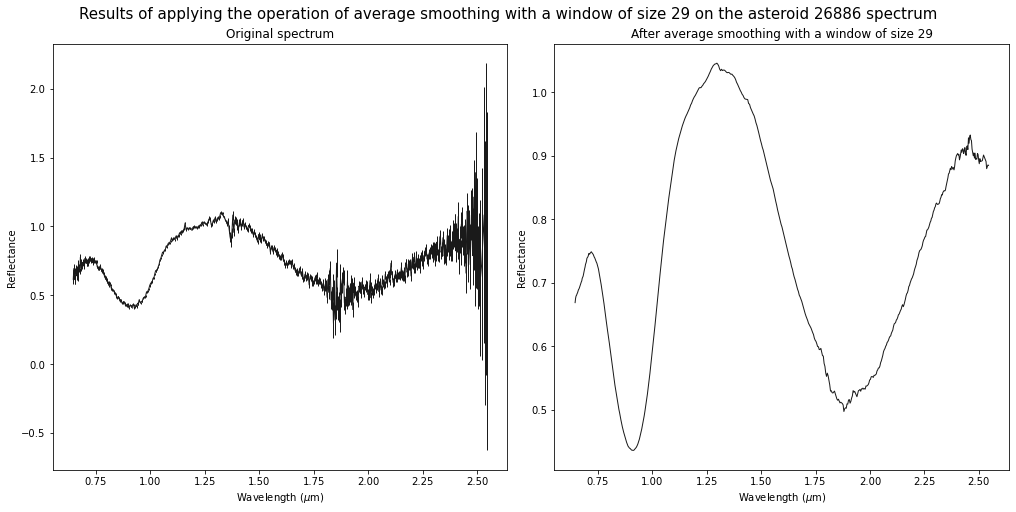

In [63]:
test_sp=irtf.spectra["26886"][0]
test_sp.apply_operation_and_compare(lambda x: x.average_smoothing(29,create_new_object=True),"average smoothing with a window of size 29", cana_function=False)
plt.savefig("comparisons_smoothing29.png")

In [303]:
color_dict={"C-complex":cm.Greys,"S-complex":cm.Blues,"X-complex":cm.Oranges,"End members":cm.Purples}
for database in [fornasier_Mtype,irtf_gartrelle,primass,smass,smass2,irtf]:
    for property_y in ["e","i","diameter","rot_per"]:
        database.report(print_report=False, make_histogram=False,nonambiguous=False,save_plot=True,save_format="jpg",properties_dependent_plot=True,property_y=property_y,cmaps=color_dict)

AttributeError: 'spectrum_database' object has no attribute 'spectra'

In [44]:
for key in irtf.spectra.keys():
    if Asteroid_info_dict[key]["a"]<1.8:
        print(key)
        for ast_key in Asteroid_info_dict[key].keys():
            if not ast_key=="spectra":
                print(ast_key, Asteroid_info_dict[key][ast_key])
        print("\n")

print("\n")

for key in irtf.spectra.keys():
    if Asteroid_info_dict[key]["diameter"]>300:
        print(key)
        for ast_key in Asteroid_info_dict[key].keys():
            if not ast_key=="spectra":
                print(ast_key, Asteroid_info_dict[key][ast_key])
        print("\n")

3103
name Eger
a 1.404
e 0.3543
i 20.93
diameter 1.5
rot_per 5.7103


2100
name Ra-Shalom
a 0.832
e 0.4365
i 15.76
diameter 2.3
rot_per 19.797


25143
name Itokawa
a 1.324
e 0.2803
i 1.62
diameter 0.33
rot_per 12.132


29075
name ?
a 1.698
e 0.5082
i 12.17
diameter 1.3
rot_per 2.1216




2
name Pallas
a 2.77
e 0.2302
i 34.93
diameter 513.0
rot_per 7.8132214


4
name Vesta
a 2.362
e 0.0894
i 7.14
diameter 525.4
rot_per 5.34212766




In [84]:
diam_min=1
i=0
for key in [irtf.taxonomies["End members"][k] for k in irtf.taxonomies["End members"].keys() if k=="V"]:
    for a in key:
        i+=1
        d=Asteroid_info_dict[a[0]]["rot_per"]
        if d>diam_min and Asteroid_info_dict[a[0]]["rot_per"]>2:
            diam_min=d
            print(a[0],Asteroid_info_dict[a[0]]["name"],Asteroid_info_dict[a[0]]["rot_per"],d)
print(i)
print("\n")
print(diam_min)

3703 Volkonskaya 3.235 3.235
4215 Kamo 12.6 12.6
956 Elisa 16.492 16.492
2045 Peking 158.7 158.7
39


158.7


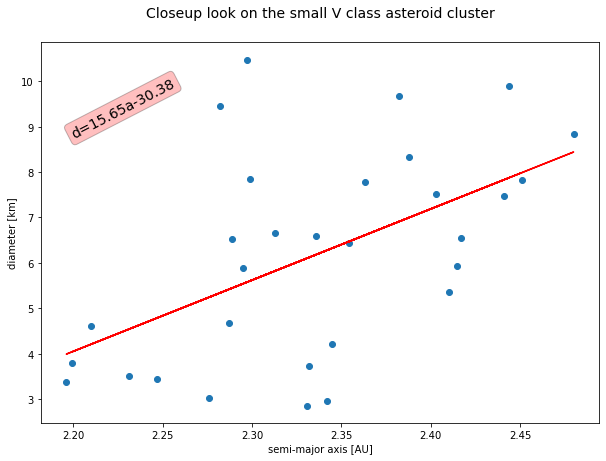

In [147]:
def linear_parameter_estimation(A,d):
    if len(A.shape)==2 and A.shape[0]==A.shape[1]:
        Ag = np.linalg.inv(A)
    else:
        prod = np.dot(A.T,A)
        if prod.shape == ():
            inv = 1.0/prod
        else:
            inv = np.linalg.inv(prod)
        Ag = np.dot(inv,A.T)
    return np.dot(Ag,d)

a=[]
ds=[]
for key in irtf.taxonomies["End members"]["V"]:
    d=Asteroid_info_dict[key[0]]["diameter"]
    if d<300:
        ds.append(d)
        a.append(Asteroid_info_dict[key[0]]["a"])
A=np.concatenate((np.array([a]),np.ones_like([np.array(a)])),axis=0)
ab=linear_parameter_estimation(A.T,np.array(ds).T)
a_coeff=ab[0]
b_coeff=ab[1]
diams_fit=a_coeff*np.array(a)+b_coeff
fig, ax=plt.subplots(figsize=(10,7))
ax.plot(a,diams_fit,color='red')
bbox = dict(boxstyle='round', fc='red', ec='black',alpha=0.25)
if b_coeff<0:
    report="d={:0.2f}a{:0.2f}".format(a_coeff,b_coeff)
else:
    report="d={:0.2f}a+{:0.2f}".format(a_coeff,b_coeff)
ax.text(0.05,0.75, report, fontsize=14, bbox=bbox,transform=ax.transAxes, horizontalalignment='left',rotation=27.2549)
ax.scatter(a,ds)
ax.set_xlabel("semi-major axis [AU]")
ax.set_ylabel("diameter [km]")
ax.set_title("Closeup look on the small V class asteroid cluster",y=1.05,fontsize=14)
fig.savefig("V_cluster_IRTF.png")

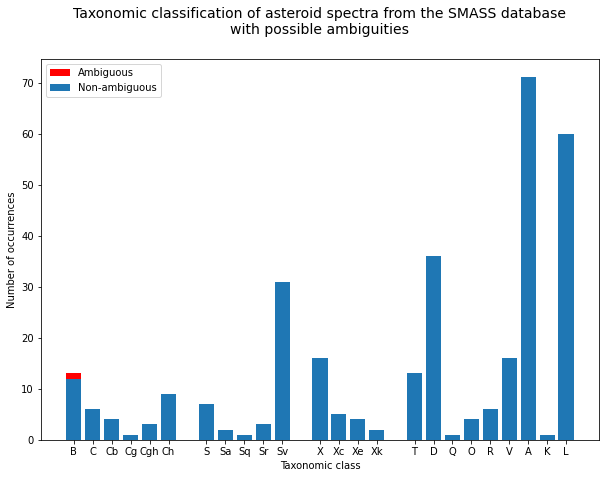

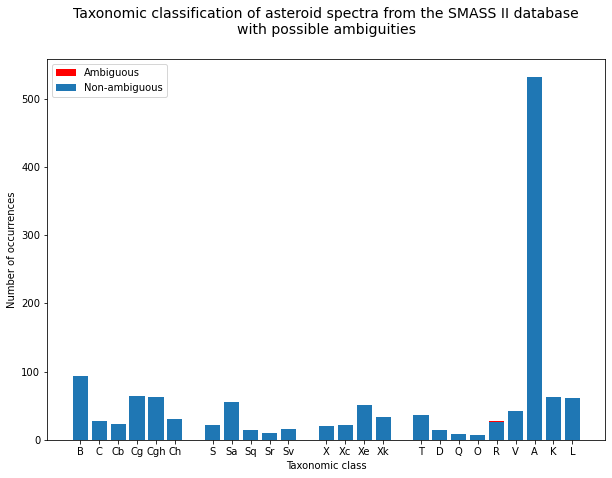

In [19]:
smass.report(print_report=False,print_names=True,make_histogram=True,nonzero=False,nonambiguous=False,save_plot=True,save_format="jpg")
smass2.report(print_report=False,print_names=True,make_histogram=True,nonzero=False,nonambiguous=False,save_plot=True,save_format="jpg")

In [22]:
irtf_gartrelle.report(print_report=True,print_names=True,make_histogram=False,nonzero=False,nonambiguous=True,save_plot=True,save_format="jpg")
irtf.report(print_report=True,print_names=True,make_histogram=False,nonzero=False,nonambiguous=True,save_plot=True,save_format="jpg")

Dataset Gartrelle IRTF representing reflectance spectra of asteroids.

Wavelength range: 0.69 - 2.54 microns.
Reflectance normalized to 1 at 1.5 microns.
Currently storing spectra of the following 25 asteroids:

End members:


    Taxonomic class D (9 asteroids):

        1167 Dubiago
        884 Priamus
        1702 Kalahari
        773 Irmintraud
        1269 Rollandia
        368 Haidea
        2893 Peiroos
        3248 Farinella
        2357 Phereclos

    Taxonomic class A (16 asteroids):

        267 Tirza
        2208 Pushkin
        2872 Gentelec
        721 ?
        3283 Skorina
        2266 Tchaikovsky
        1746 Brouwer
        1542 Schalen
        4744 Rovereto
        1583 Antilochus
        2311 El
        2674 Pandarus
        2207 Antenor
        1256 Normannia
        2246 Bowell
        336 Lacadiera

Dataset IRTF representing reflectance spectra of asteroids.

Wavelength range: 0.65 - 2.55 microns.
Reflectance normalized to 1 at 1.215 microns.
Currently storing sp

In [27]:
for key in irtf.taxonomies["End members"]["D"]:
    if key[1]:
        print(key)
        for sp in irtf.spectra[key[0]]:
            print(sp.taxonomy_options)

['129', True]
['D', 'Sa', 'X']
['D', 'X', 'T']
['A', 'Sa', 'D']
['D', 'X', 'T']
['D', 'Sa', 'X']
['D', 'X', 'T']
['D', 'Sa', 'X']
['D', 'X', 'T']
['D', 'Sa', 'X']
['D', 'X', 'T']
['D', 'X', 'T']
['X', 'T', 'Cb']
['D', 'Sa', 'R']
['D', 'Sa', 'X']
['Sa', 'D', 'A']
['785', True]
['D', 'X', 'T']
['X', 'D', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['X', 'D', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'Sa']
['D', 'X', 'T']
['D', 'X', 'T']
['D', 'X', 'T']
['771', True]
['D', 'Sa', 'X']
['D', 'Sa', 'X']
['D', 'X', 'T']
['D', 'Sa', 'R']
['X', 'T', 'D']
['D', 'Sa', 'X']
['497', True]
['X', 'D', 'T']
['X', 'D', 'T']
['D', 'X', 'Sa']
['D', 'Sq', 'X']
['D', 'X', 'Sq']
['D', 'X', 'T']
['547', True]
['Sq', 'Q', 'T']
['D', 'X', 'T']
['559', True]
['Cb', 'C', 'T']
['D', 'X', 'T']
['135', True]
['X

In [20]:
test_database = irtf_gartrelle
for num in [x[0] for x in test_database.taxonomies["End members"]["A"]]: 
    print(num)
    for sp in test_database.spectra[num]:
        print(sp.taxonomy_options,sp.taxonomy_chi2s)

AttributeError: 'spectrum_database' object has no attribute 'taxonomies'

In [187]:
def cana_clean(C):
    return C.clean_spec()

def cana_rebin(C):
    return C.rebin(std=False)

def cana_fit(C):
    return C.fit()[0]

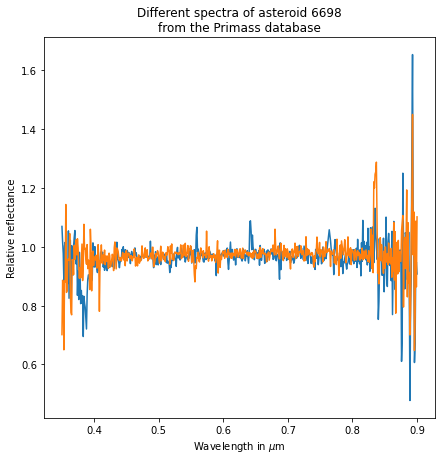

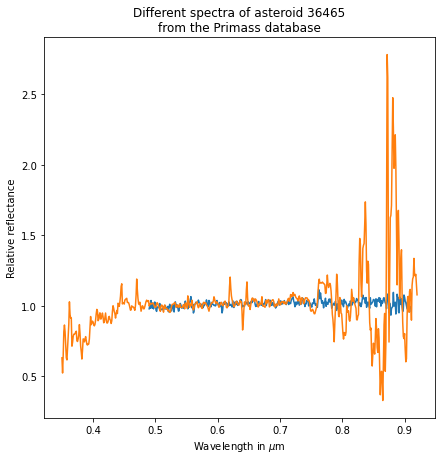

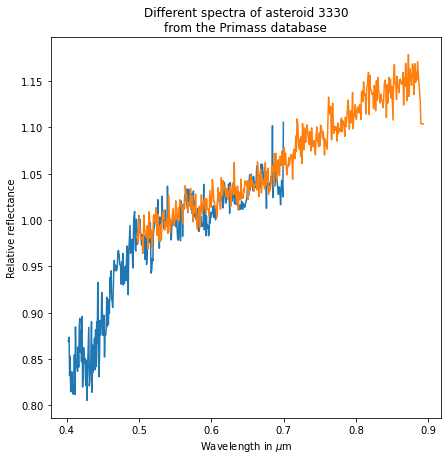

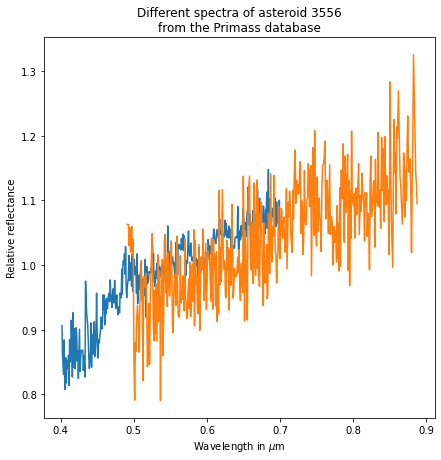

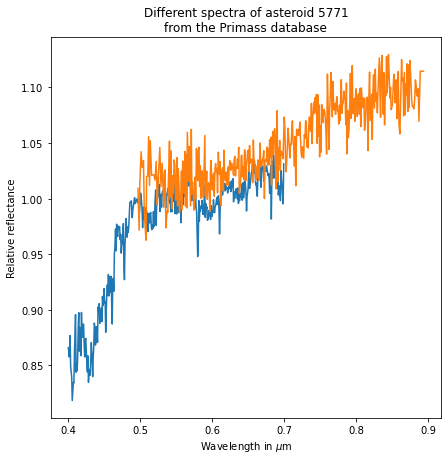

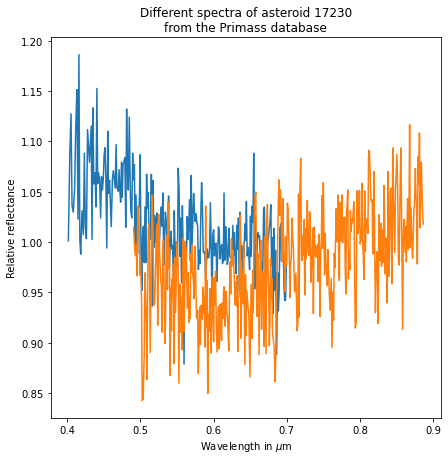

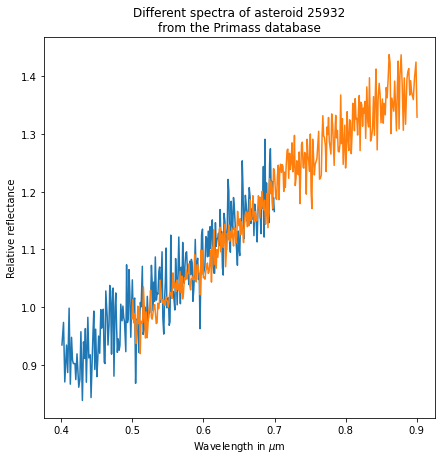

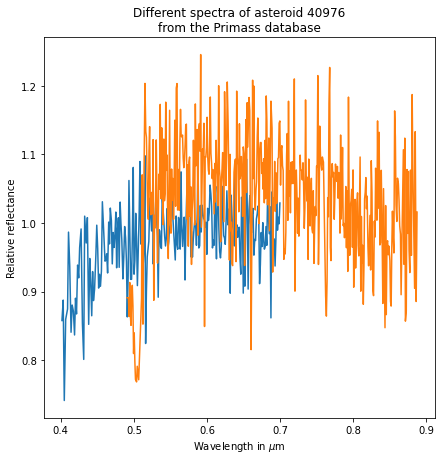

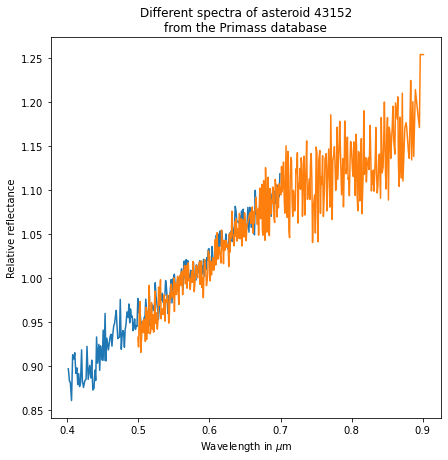

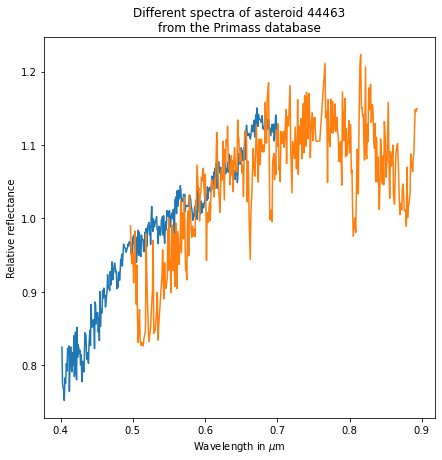

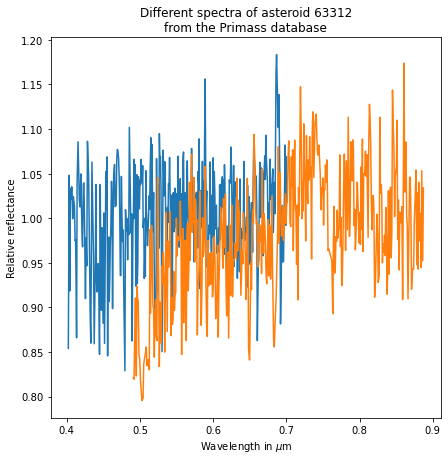

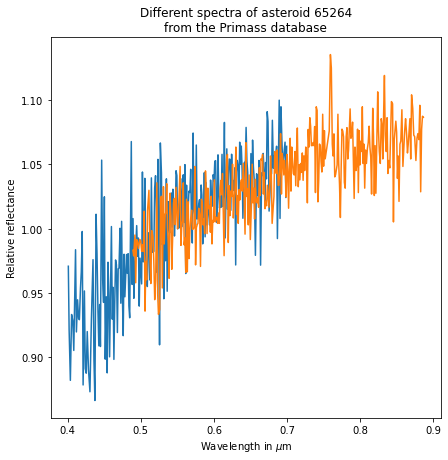

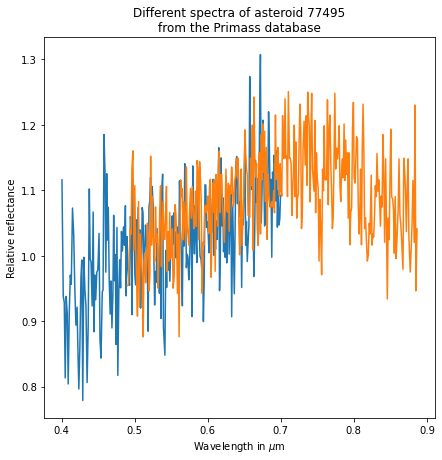

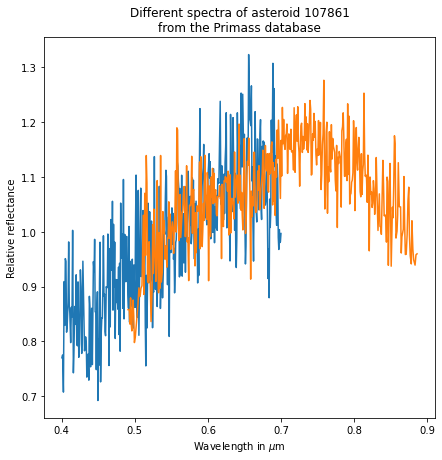

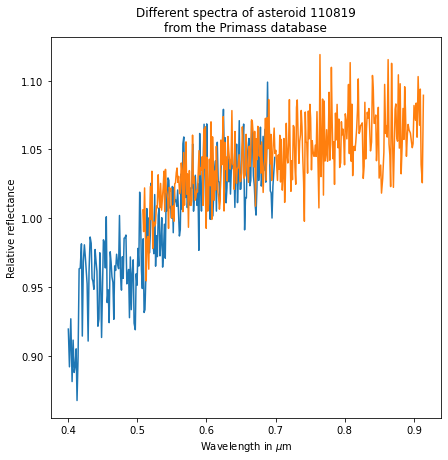

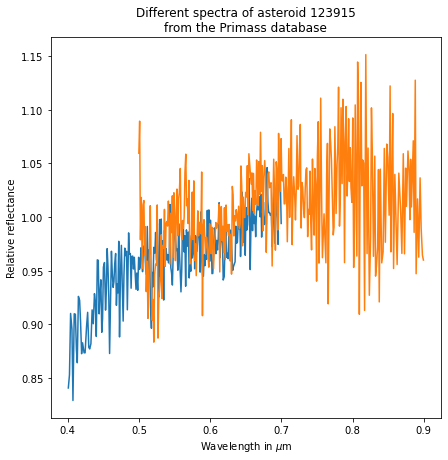

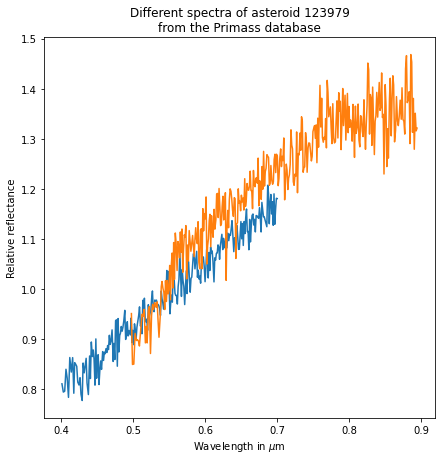

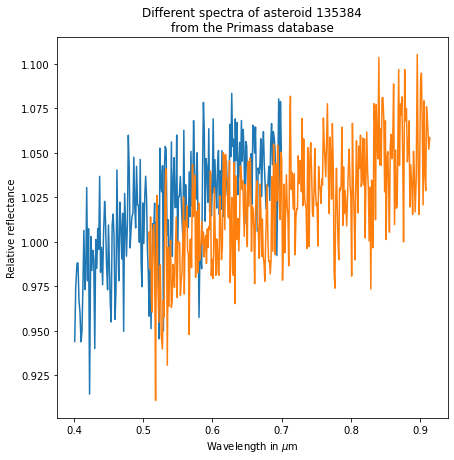

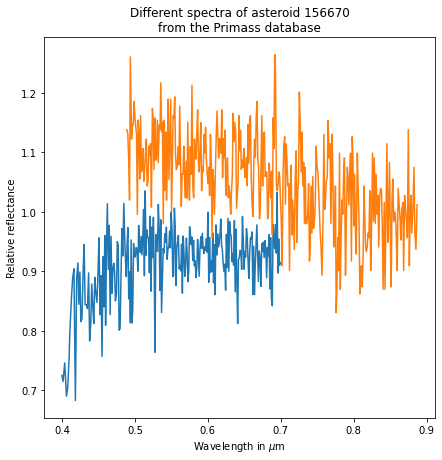

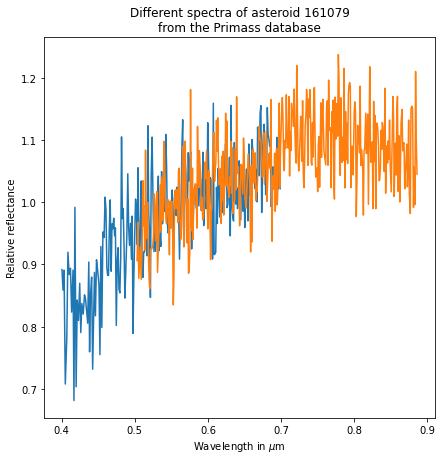

In [40]:
for ast in primass.spectra.keys():
    if len(primass.spectra[ast])>1:
        primass.plot_all_together(int(ast))

In [37]:
primass.change_directory_name("Primass",new_tag="Primass")

In [110]:
page = requests.get("https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=1356")
soup = BeautifulSoup(page.content, 'html.parser')
print(soup)
movies = []
for row in soup.select('tbody.lister-list tr'):
    print(row)
    title = row.find('td', class_='ng.isolate_scope').get_text()
    print(title)

<!DOCTYPE html>

<html class="no-js" lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="nofollow" name="robots"/>
<link href="data:;base64,iVBORw0KGgo=" rel="icon"/><!-- prevent favicon.ico noise -->
<link href="/css/font-awesome.min.css" rel="stylesheet"/>
<!--<link rel="stylesheet" href="/css/dataTables.fontAwesome.css" />-->
<link href="/css/dataTables.bootstrap.min.css" rel="stylesheet"/>
<link href="/css/responsive.bootstrap.min.css" rel="stylesheet"/>
<link href="/tools/sbdb_lookup/css/app.css" rel="stylesheet"/>
<link href="/css/styles.css" rel="stylesheet"/>
<title>Small-Body Database Lookup</title>
</head>
<body>
<a class="sr-only sr-only-focusable" href="#main_content">Skip Navigation</a>
<div class="top-banner" id="banner">
<img alt="banner" class="img-responsive banner" src="/images/ssd_banner.png"/>
<img alt="banner" class="img-responsive banne